# 教程8: 转录动力学分析

在本节中，我们将深入挖掘视网膜退化与视神经退化背后的转录动力学原理，希望找到视网膜退化的相关基因

In [1]:
#导入包
import anndata
print('anndata(Ver): ',anndata.__version__)
import scanpy as sc
print('scanpy(Ver): ',sc.__version__)
import matplotlib.pyplot as plt
import matplotlib
print('matplotlib(Ver): ',matplotlib.__version__)
import seaborn as sns
print('seaborn(Ver): ',sns.__version__)
import numpy as np
print('numpy(Ver): ',np.__version__)
import pandas as pd
print('pandas(Ver): ',pd.__version__)
import scvelo as scv
print('scvelo(Ver): ',scv.__version__)
import Pyomic
print('Pyomic(Ver): ',Pyomic.__version__)
import pyVIA.core as via
#print('pyVIA(Ver): ',via.__version__)


#绘图参数设置
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

from matplotlib.colors import LinearSegmentedColormap
sc_color=['#7CBB5F','#368650','#A499CC','#5E4D9A','#78C2ED','#866017', '#9F987F','#E0DFED',
 '#EF7B77', '#279AD7','#F0EEF0', '#1F577B', '#A56BA7', '#E0A7C8', '#E069A6', '#941456', '#FCBC10',
 '#EAEFC5', '#01A0A7', '#75C8CC', '#F0D7BC', '#D5B26C', '#D5DA48', '#B6B812', '#9DC3C3', '#A89C92', '#FEE00C', '#FEF2A1']
sc_color_cmap = LinearSegmentedColormap.from_list('Custom', sc_color, len(sc_color))

anndata(Ver):  0.8.0
scanpy(Ver):  1.9.1
matplotlib(Ver):  3.5.1
seaborn(Ver):  0.11.2
numpy(Ver):  1.22.3
pandas(Ver):  1.3.5
scvelo(Ver):  0.2.4
Pyomic(Ver):  1.1.4


2023-03-13 04:15:31.154159: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 04:15:31.240674: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-13 04:15:31.240707: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-13 04:15:31.722315: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

/home/leihu/pyomic/lib/python3.8/site-packages/phate/__init__.py


## 1. 绘图函数重定义

由于pyVIA自带的`draw_piechart_graph`无法根据我们的细胞类型上色，所以我们构建一个新的函数来完成这个目的

In [2]:
from pyVIA.utils_via import *
from pyVIA.plotting_via import *
def draw_piechart_graph(adata,clusters,via_object, type_data='pt', gene_exp:list=[], title='', cmap:str=None, ax_text=True, dpi=150,headwidth_arrow = 0.1, alpha_edge=0.4, linewidth_edge=2, edge_color='darkblue',reference=None, show_legend:bool=True, pie_size_scale:float=0.8, fontsize:float=8):
    '''
    plot two subplots with a clustergraph level representation of the viagraph showing true-label composition (lhs) and pseudotime/gene expression (rhs)
    Returns matplotlib figure with two axes that plot the clustergraph using edge bundling
    left axis shows the clustergraph with each node colored by annotated ground truth membership.
    right axis shows the same clustergraph with each node colored by the pseudotime or gene expression
    :param via_object: is class VIA (the same function also exists as a method of the class and an external plotting function
    :param type_data: string  default 'pt' for pseudotime colored nodes. or 'gene'
    :param gene_exp: list of values (column of dataframe) corresponding to feature or gene expression to be used to color nodes at CLUSTER level
    :param title: string
    :param cmap: default None. automatically chooses coolwarm for gene expression or viridis_r for pseudotime
    :param ax_text: Bool default= True. Annotates each node with cluster number and population of membership
    :param dpi: int default = 150
    :param headwidth_bundle: default = 0.1. width of arrowhead used to directed edges
    :param reference: None or list. list of categorical (str) labels for cluster composition of the piecharts (LHS subplot) length = n_samples.
    :param pie_size_scale: float default=0.8 scaling factor of the piechart nodes
    :return: f, ax, ax1
    '''

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    f, ((ax, ax1)) = plt.subplots(1, 2, sharey=True, dpi=dpi)

    node_pos = via_object.graph_node_pos

    node_pos = np.asarray(node_pos)
    if cmap is None: cmap = 'coolwarm' if type_data == 'gene' else 'viridis_r'

    if type_data == 'pt':
        pt = via_object.scaled_hitting_times  # these are the final MCMC refined pt then slightly scaled at cluster level
        title_ax1 = "Pseudotime"

    if type_data == 'gene':
        pt = gene_exp
        title_ax1 = title
    if reference is None: reference_labels=via_object.true_label
    else: reference_labels = reference
    n_groups = len(set(via_object.labels))
    n_truegroups = len(set(reference_labels))
    group_pop = np.zeros([n_groups, 1])
    group_frac = pd.DataFrame(np.zeros([n_groups, n_truegroups]), columns=list(adata.obs[clusters].cat.categories))
    via_object.cluster_population_dict = {}
    for group_i in set(via_object.labels):
        loc_i = np.where(via_object.labels == group_i)[0]

        group_pop[group_i] = len(loc_i)  # np.sum(loc_i) / 1000 + 1
        via_object.cluster_population_dict[group_i] = len(loc_i)
        true_label_in_group_i = list(np.asarray(reference_labels)[loc_i])
        for ii in set(true_label_in_group_i):
            group_frac[ii][group_i] = true_label_in_group_i.count(ii)

    line_true = np.linspace(0, 1, n_truegroups)
    color_true_list = [plt.cm.rainbow(color) for color in line_true]
    color_true_list=adata.uns['{}_colors'.format(clusters)]

    sct = ax.scatter(node_pos[:, 0], node_pos[:, 1],
                     c='white', edgecolors='face', s=group_pop, cmap='jet')

    bboxes = getbb(sct, ax)

    ax = plot_edgebundle_viagraph(ax, via_object.hammerbundle_cluster, layout=via_object.graph_node_pos, CSM=via_object.CSM,
                            velocity_weight=via_object.velo_weight, pt=pt, headwidth_bundle=headwidth_arrow,
                            alpha_bundle=alpha_edge,linewidth_bundle=linewidth_edge, edge_color=edge_color)

    trans = ax.transData.transform
    bbox = ax.get_position().get_points()
    ax_x_min = bbox[0, 0]
    ax_x_max = bbox[1, 0]
    ax_y_min = bbox[0, 1]
    ax_y_max = bbox[1, 1]
    ax_len_x = ax_x_max - ax_x_min
    ax_len_y = ax_y_max - ax_y_min
    trans2 = ax.transAxes.inverted().transform
    pie_axs = []
    pie_size_ar = ((group_pop - np.min(group_pop)) / (np.max(group_pop) - np.min(group_pop)) + 0.5) / 10  # 10

    for node_i in range(n_groups):

        cluster_i_loc = np.where(np.asarray(via_object.labels) == node_i)[0]
        majority_true = via_object.func_mode(list(np.asarray(reference_labels)[cluster_i_loc]))
        pie_size = pie_size_ar[node_i][0] *pie_size_scale

        x1, y1 = trans(node_pos[node_i])  # data coordinates
        xa, ya = trans2((x1, y1))  # axis coordinates

        xa = ax_x_min + (xa - pie_size / 2) * ax_len_x
        ya = ax_y_min + (ya - pie_size / 2) * ax_len_y
        # clip, the fruchterman layout sometimes places below figure
        if ya < 0: ya = 0
        if xa < 0: xa = 0
        rect = [xa, ya, pie_size * ax_len_x, pie_size * ax_len_y]
        frac = np.asarray([ff for ff in group_frac.iloc[node_i].values])

        pie_axs.append(plt.axes(rect, frameon=False))
        pie_axs[node_i].pie(frac, wedgeprops={'linewidth': 0.0}, colors=color_true_list)
        pie_axs[node_i].set_xticks([])
        pie_axs[node_i].set_yticks([])
        pie_axs[node_i].set_aspect('equal')
        # pie_axs[node_i].text(0.5, 0.5, graph_node_label[node_i])
        if ax_text==True: pie_axs[node_i].text(0.5, 0.5, majority_true, fontsize = fontsize )

    patches, texts = pie_axs[node_i].pie(frac, wedgeprops={'linewidth': 0.0}, colors=color_true_list)
    labels = list(set(reference_labels))
    if show_legend ==True: plt.legend(patches, labels, loc=(-5, -5), fontsize=6, frameon=False)

    if via_object.time_series==True:
        ti = 'Cluster Composition. K=' + str(via_object.knn) + '. ncomp = ' + str(via_object.ncomp)  +'knnseq_'+str(via_object.knn_sequential)# "+ is_sub
    else:
        ti = 'Cluster Composition. K=' + str(via_object.knn) + '. ncomp = ' + str(via_object.ncomp)
    ax.set_title(ti)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

    title_list = [title_ax1]
    for i, ax_i in enumerate([ax1]):
        pt = via_object.markov_hitting_times if type_data == 'pt' else gene_exp

        c_edge, l_width = [], []
        for ei, pti in enumerate(pt):
            if ei in via_object.terminal_clusters:
                c_edge.append('red')
                l_width.append(1.5)
            else:
                c_edge.append('gray')
                l_width.append(0.0)

        gp_scaling = 1000 / max(group_pop)

        group_pop_scale = group_pop * gp_scaling * 0.5
        ax_i=plot_edgebundle_viagraph(ax_i, via_object.hammerbundle_cluster, layout=via_object.graph_node_pos,CSM=via_object.CSM, velocity_weight=via_object.velo_weight, pt=pt,headwidth_bundle=headwidth_arrow, alpha_bundle=alpha_edge, linewidth_bundle=linewidth_edge, edge_color=edge_color)

        im1 = ax_i.scatter(node_pos[:, 0], node_pos[:, 1], s=group_pop_scale, c=pt, cmap=cmap,
                           edgecolors=c_edge,
                           alpha=1, zorder=3, linewidth=l_width)
        if ax_text:
            x_max_range = np.amax(node_pos[:, 0]) / 100
            y_max_range = np.amax(node_pos[:, 1]) / 100

            for ii in range(node_pos.shape[0]):
                ax_i.text(node_pos[ii, 0] + max(x_max_range, y_max_range),
                          node_pos[ii, 1] + min(x_max_range, y_max_range),
                          'C' + str(ii) + 'pop' + str(int(group_pop[ii][0])),
                          color='black', zorder=4, fontsize = fontsize)
        ax_i.set_title(title_list[i])
        ax_i.grid(False)
        ax_i.set_xticks([])
        ax_i.set_yticks([])

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    if type_data == 'pt':
        f.colorbar(im1, cax=cax, orientation='vertical', label='pseudotime',shrink=0.5)
    else:
        f.colorbar(im1, cax=cax, orientation='vertical', label='Gene expression',shrink=0.5)
    f.patch.set_visible(False)

    ax1.axis('off')
    ax.axis('off')
    ax.set_facecolor('white')
    ax1.set_facecolor('white')
    return f, ax, ax1

## 2. RNA Velocity分析

在这里，我们计算了视网膜细胞的转录动力学，使用动力学模型进行恢复

### 2.1 读取数据并过滤

我们只需要视网膜细胞，所以我们根据四个类型过滤一下

In [4]:
current_path='/home/leihu/data/analysis/rb_tutorial/'
rna=sc.read(current_path+'data/analysis1/rna_anno.h5ad')

In [7]:
adata=rna[rna.obs['major_celltype'].isin(['P-Photoreceptor cells', 'Photoreceptor cells','Retinal stem cells', 'STER cells'])]
adata

View of AnnData object with n_obs × n_vars = 13431 × 2000
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'Tissue', 'Developmental_Stage', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'domain', 'leiden', 'balancing_weight', 'n_counts', 'major_celltype', 'obs_index_raw'
    var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'End', 'Start', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'ID', 'copy_num_ID', 'coverage', 'db_xref', 'extra_copy_number', 'gbkey', 'gene', 'gene_biotype', 'gene_name', 'dell', 'dispersions', 'dispersions_norm'
    uns: 'Developmental_Stage_colors', '__scglue__', 'cosg', 'dendrogram_leiden', 'den

In [8]:
sc.tl.pca(adata, n_comps=100, svd_solver="arpack")
sc.pp.neighbors(adata, use_rep="X_pca", metric="cosine",n_neighbors=100, random_state = 112)
sc.tl.leiden(adata)
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata,init_pos='paga')

computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:06)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:20)
running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:06)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)


### 2.2 过滤少量细胞

leiden是邻域聚类算法，作为一个无监督聚类，可能有一些类别里的细胞数小于100，为了避免干扰注释分析，我们选择将其过滤

In [9]:
adata.obs['leiden'].value_counts()[adata.obs['leiden'].value_counts()<100].index
adata=adata[~adata.obs['leiden'].isin(adata.obs['leiden'].value_counts()[adata.obs['leiden'].value_counts()<100].index)]
adata

View of AnnData object with n_obs × n_vars = 13315 × 2000
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'Tissue', 'Developmental_Stage', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'domain', 'leiden', 'balancing_weight', 'n_counts', 'major_celltype', 'obs_index_raw'
    var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'End', 'Start', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'ID', 'copy_num_ID', 'coverage', 'db_xref', 'extra_copy_number', 'gbkey', 'gene', 'gene_biotype', 'gene_name', 'dell', 'dispersions', 'dispersions_norm'
    uns: 'Developmental_Stage_colors', '__scglue__', 'cosg', 'dendrogram_leiden', 'den

### 2.3 动力学模型恢复

原教程为：https://scvelo.readthedocs.io/en/stable/DynamicalModeling/

我们运行动力学模型来学习剪接动力学的完整转录动力学。

通过迭代估计反应速率和潜伏细胞特异性变量(即转录状态和细胞内潜伏时间)的参数，在基于似然的期望最大化框架下求解。因此，它的目的是学习每个基因的非剪接/剪接相轨迹。

In [10]:
scv.tl.recover_dynamics(adata,n_jobs=10)

recovering dynamics (using 10/12 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:57) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [11]:
scv.tl.velocity(adata, mode='dynamical',show_progress_bar=False)
scv.tl.velocity_graph(adata,n_jobs=10)

computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 10/12 cores)
    finished (0:00:20) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:03) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


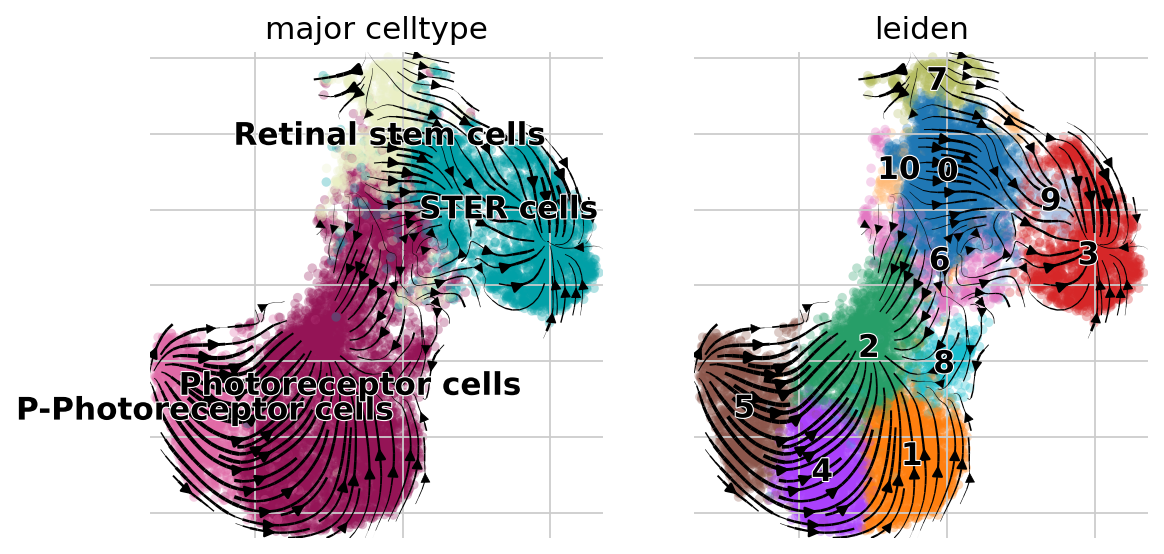

In [12]:
scv.pl.velocity_embedding_stream(adata, basis='umap',color=['major_celltype','leiden'])

### 2.4 潜伏时间计算

该动态模型恢复了基础细胞过程的潜伏时间。这个潜伏时间代表了细胞的内部时钟，并近似于细胞分化时经历的真实时间，只基于其转录动态。

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:04) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:03) --> added 
    'latent_time', shared time (adata.obs)


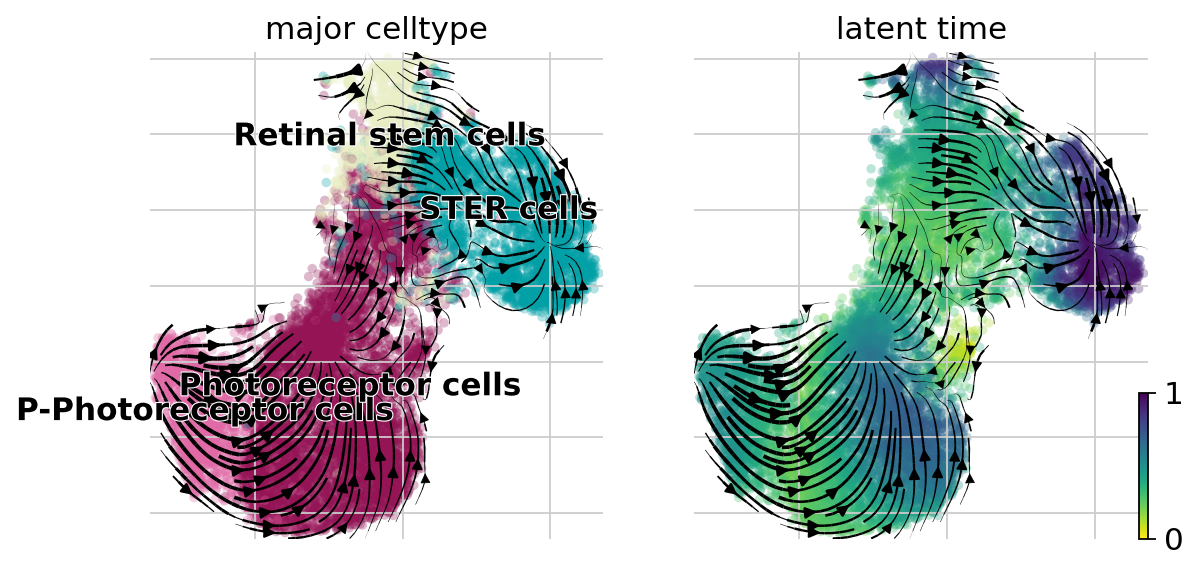

In [13]:
scv.tl.latent_time(adata)
scv.pl.velocity_embedding_stream(adata, basis='umap',color=['major_celltype','latent_time'])

In [14]:
adata.write_h5ad(current_path+'data/analysis3/photo.h5ad',compression='gzip')

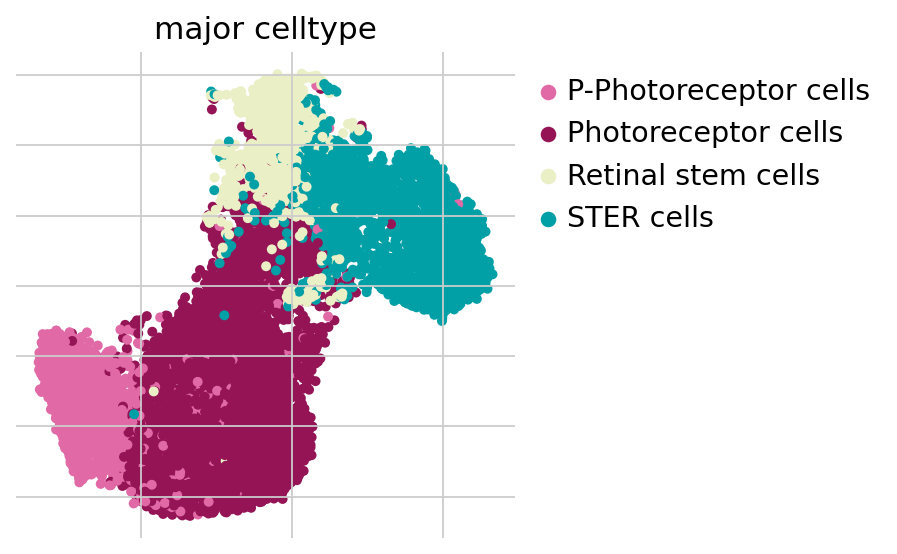

In [15]:
scv.pl.scatter(adata, color='major_celltype', color_map='Reds',show=False, size=80)
plt.savefig(current_path+'result/analysis3/all_celltype.png',dpi=300,bbox_inches='tight')

### 2.5 细胞亚型注释

我们前面的注释只是得到了大类细胞，其实一类细胞里的细胞可能执行不同的功能，所以我们进行亚类注释

In [16]:
retina_dict_chatgpt = {
    'Photoreceptor cells': ['RHO', 'CRX', 'RCVRN', 'SAG'],
    'Bipolar cells': ['PRKCA', 'NRGN', 'TH', 'CCK'],
    'Horizontal cells': ['CALB1', 'GABRA1', 'PRKCA'],
    'Amacrine cells': ['SLC6A1', 'CALB2', 'SLC6A9', 'SST'],
    'Retinal ganglion cells': ['POU4F1', 'THY1', 'NEFL', 'TUBB3', 'ISL1', 'ATOH7'],
    'Müller glia cells': ['GLUL', 'VIM', 'RLBP1', 'CSPG4'],
    'Rod photoreceptor cells': ['RHO', 'CNGB1', 'GNAT1', 'SAG'],
    'Cone photoreceptor cells': ['CRX', 'OPN1LW', 'OPN1MW', 'OPN1SW', 'GNAT2'],
    'Retinal pigment epithelium (RPE) cells': ['BEST1', 'RLBP1', 'RPE65', 'TYR'],
    'Microglia cells': ['IBA1', 'CD68',  'TREM2'],
    'Astrocytes': ['GFAP', 'S100B', 'AQP4', 'GJA1'],
    'Retinal progenitor cells (RPCs)': ['PAX6', 'NESTIN', 'SOX2', 'VSX2'],
    'Pericytes': ['PDGFRB', 'ACTA2', 'CD13', 'RGS5'],
    'Myeloid cells': ['CD45',  'CD68', 'CD163']
}
all_genes=adata.raw.var.index.tolist()
for key in retina_dict_chatgpt.keys():
    for gene in retina_dict_chatgpt[key]:
        if gene not in all_genes:
            retina_dict_chatgpt[key].remove(gene)
retina_dict_chatgpt         

{'Photoreceptor cells': ['RHO', 'CRX', 'RCVRN', 'SAG'],
 'Bipolar cells': ['PRKCA', 'NRGN', 'TH', 'CCK'],
 'Horizontal cells': ['CALB1', 'GABRA1', 'PRKCA'],
 'Amacrine cells': ['SLC6A1', 'CALB2', 'SLC6A9', 'SST'],
 'Retinal ganglion cells': ['POU4F1',
  'THY1',
  'NEFL',
  'TUBB3',
  'ISL1',
  'ATOH7'],
 'Müller glia cells': ['GLUL', 'VIM', 'RLBP1', 'CSPG4'],
 'Rod photoreceptor cells': ['RHO', 'CNGB1', 'GNAT1', 'SAG'],
 'Cone photoreceptor cells': ['CRX', 'OPN1LW', 'OPN1MW', 'OPN1SW', 'GNAT2'],
 'Retinal pigment epithelium (RPE) cells': ['BEST1', 'RLBP1', 'RPE65', 'TYR'],
 'Microglia cells': ['CD68', 'TREM2'],
 'Astrocytes': ['GFAP', 'S100B', 'AQP4', 'GJA1'],
 'Retinal progenitor cells (RPCs)': ['PAX6', 'SOX2', 'VSX2'],
 'Pericytes': ['ACTA2', 'RGS5'],
 'Myeloid cells': ['CD68', 'CD163']}

    using 'X_pca' with n_pcs = 100
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 2, etc.
var_group_labels: Photoreceptor cells, Bipolar cells, Horizontal cells, etc.


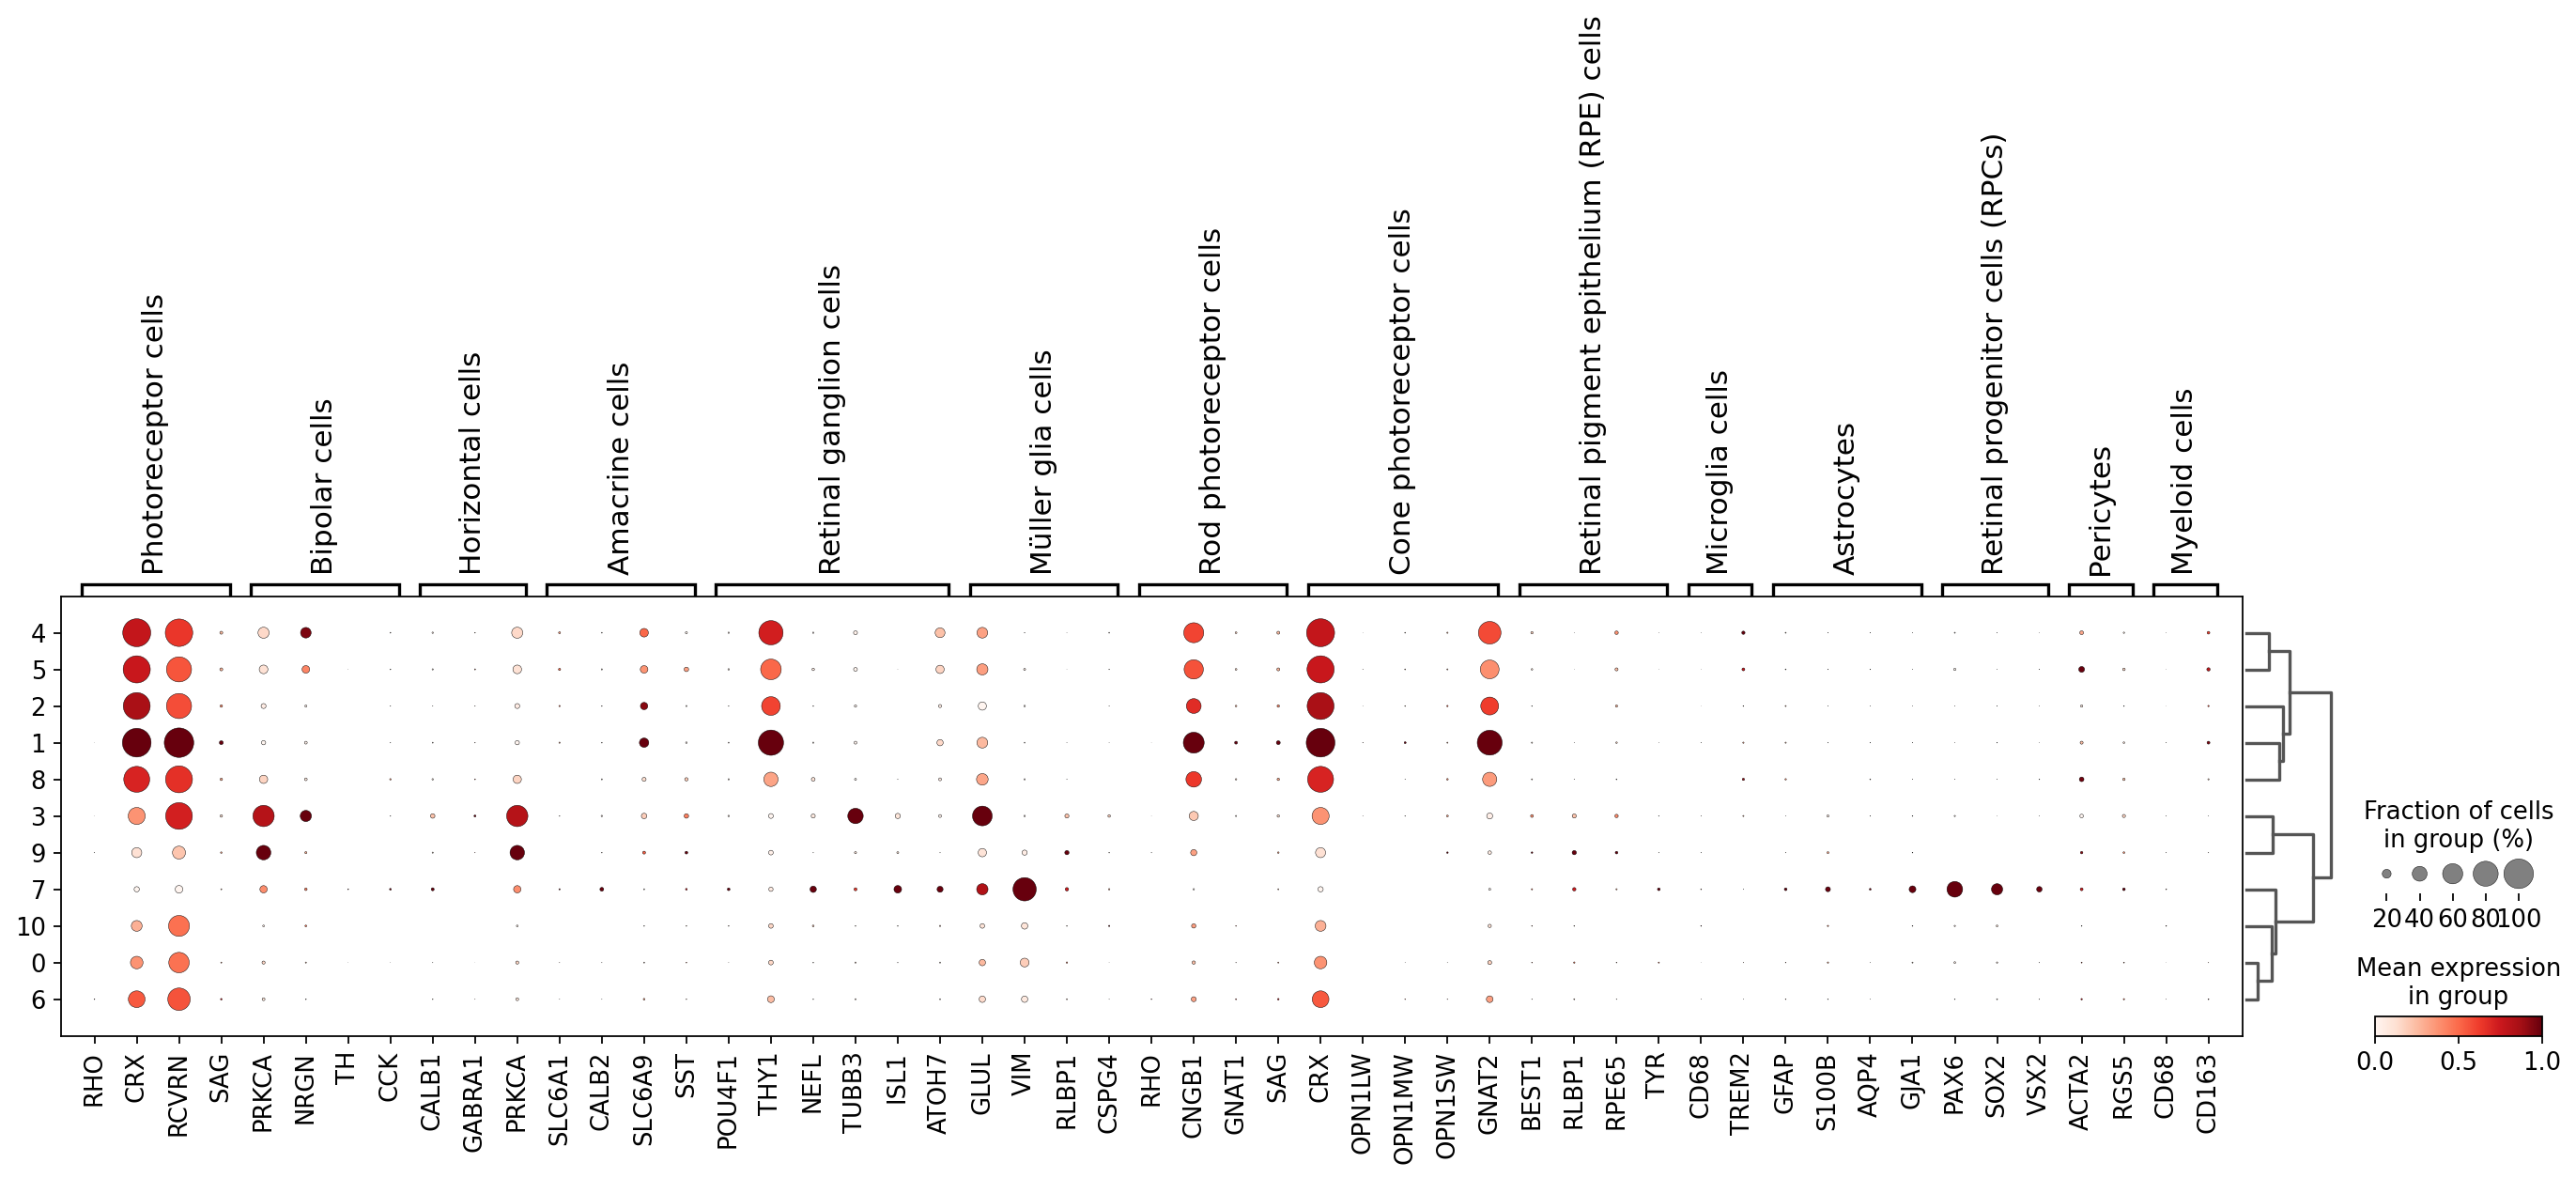

In [17]:
sc.tl.dendrogram(adata,'leiden')
sc.pl.dotplot(adata, retina_dict_chatgpt, 'leiden', dendrogram=True,standard_scale='var')

    using 'X_pca' with n_pcs = 100
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 2, etc.
var_group_labels: Retinal stem cells, Photoreceptor cells, P-Photoreceptor cells, etc.


{'mainplot_ax': <AxesSubplot:>,
 'group_extra_ax': <AxesSubplot:>,
 'gene_group_ax': <AxesSubplot:>,
 'size_legend_ax': <AxesSubplot:title={'center':'Fraction of cells\nin group (%)'}>,
 'color_legend_ax': <AxesSubplot:title={'center':'Mean expression\nin group'}>}

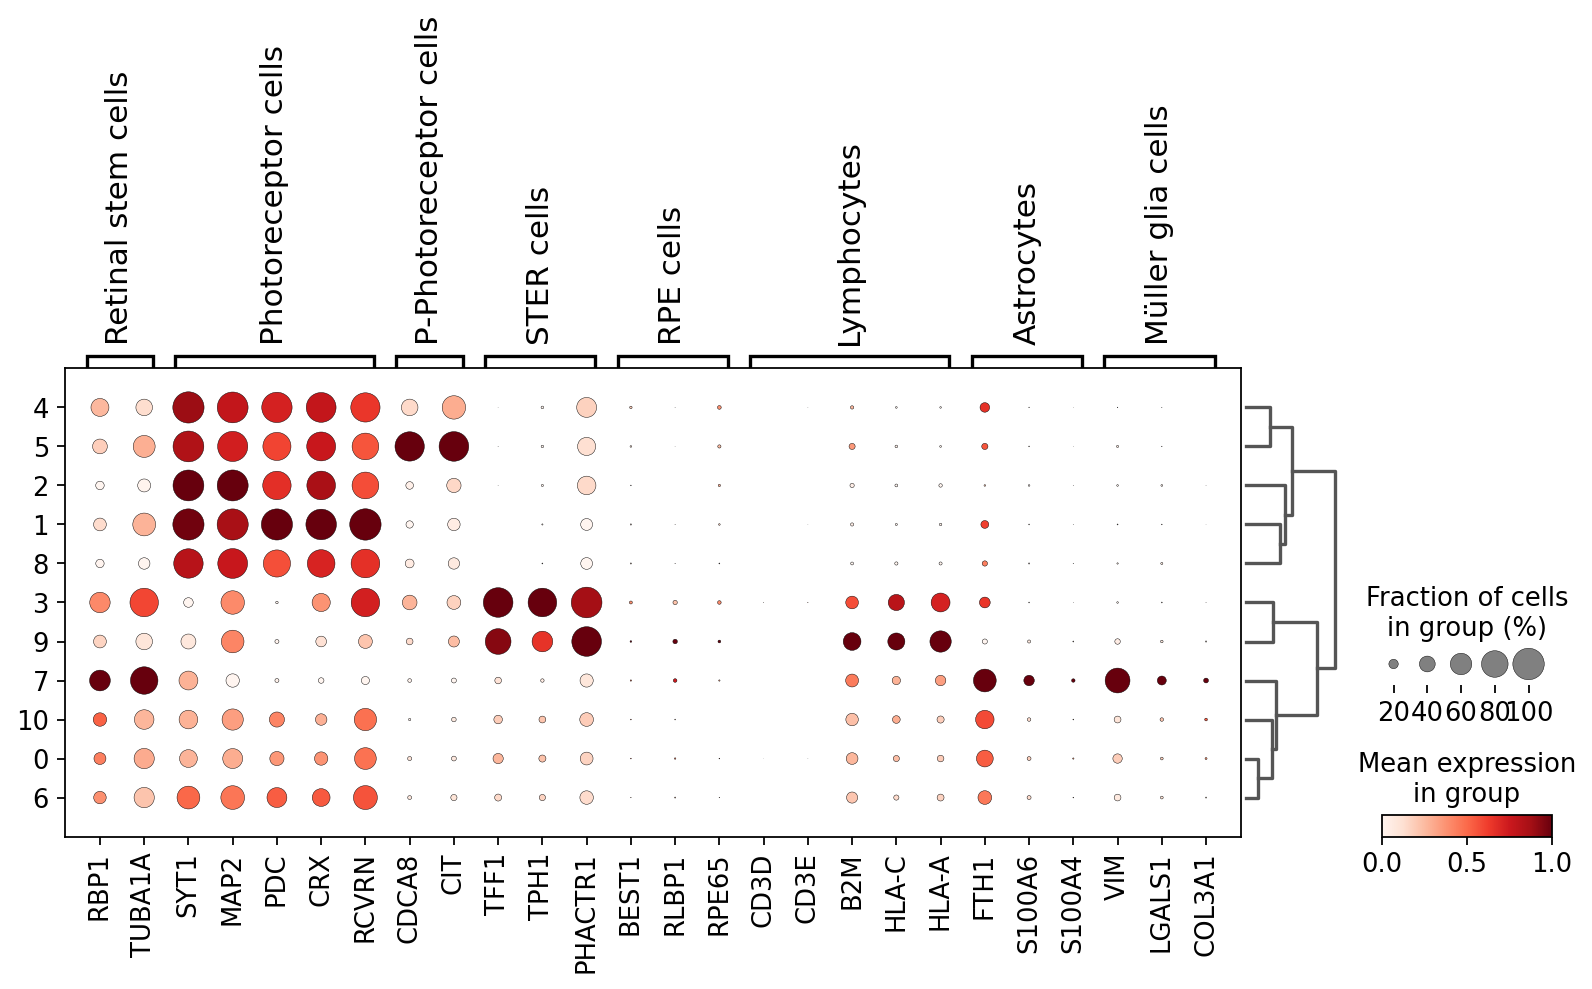

In [71]:
retina_dict={
    'Retinal stem cells':['RBP1','TUBA1A'],
    'Photoreceptor cells':['SYT1','MAP2','PDC','CRX', 'RCVRN',],
    'P-Photoreceptor cells':['CDCA8','CIT',],
    'STER cells':['TFF1','TPH1','PHACTR1'],
    'RPE cells':['BEST1', 'RLBP1', 'RPE65',],
    'Lymphocytes':['CD3D','CD3E','B2M','HLA-C','HLA-A'],
    'Astrocytes':['FTH1','S100A6','S100A4'],
    'Müller glia cells':['VIM','LGALS1','COL3A1'],
}
sc.tl.dendrogram(adata,'leiden')
sc.pl.dotplot(adata, retina_dict, 'leiden', dendrogram=True,standard_scale='var',show=False)
#plt.savefig(current_path+'result_1/retina_celltype.png',dpi=300,bbox_inches='tight')

In [19]:
sc.tl.dendrogram(adata,'leiden')
adata.uns['log1p']['base']=None
sc.tl.rank_genes_groups(adata, 'leiden', 
                        use_raw=False,
                        method='t-test',n_genes=100)


    using 'X_pca' with n_pcs = 100
Storing dendrogram info using `.uns['dendrogram_leiden']`
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


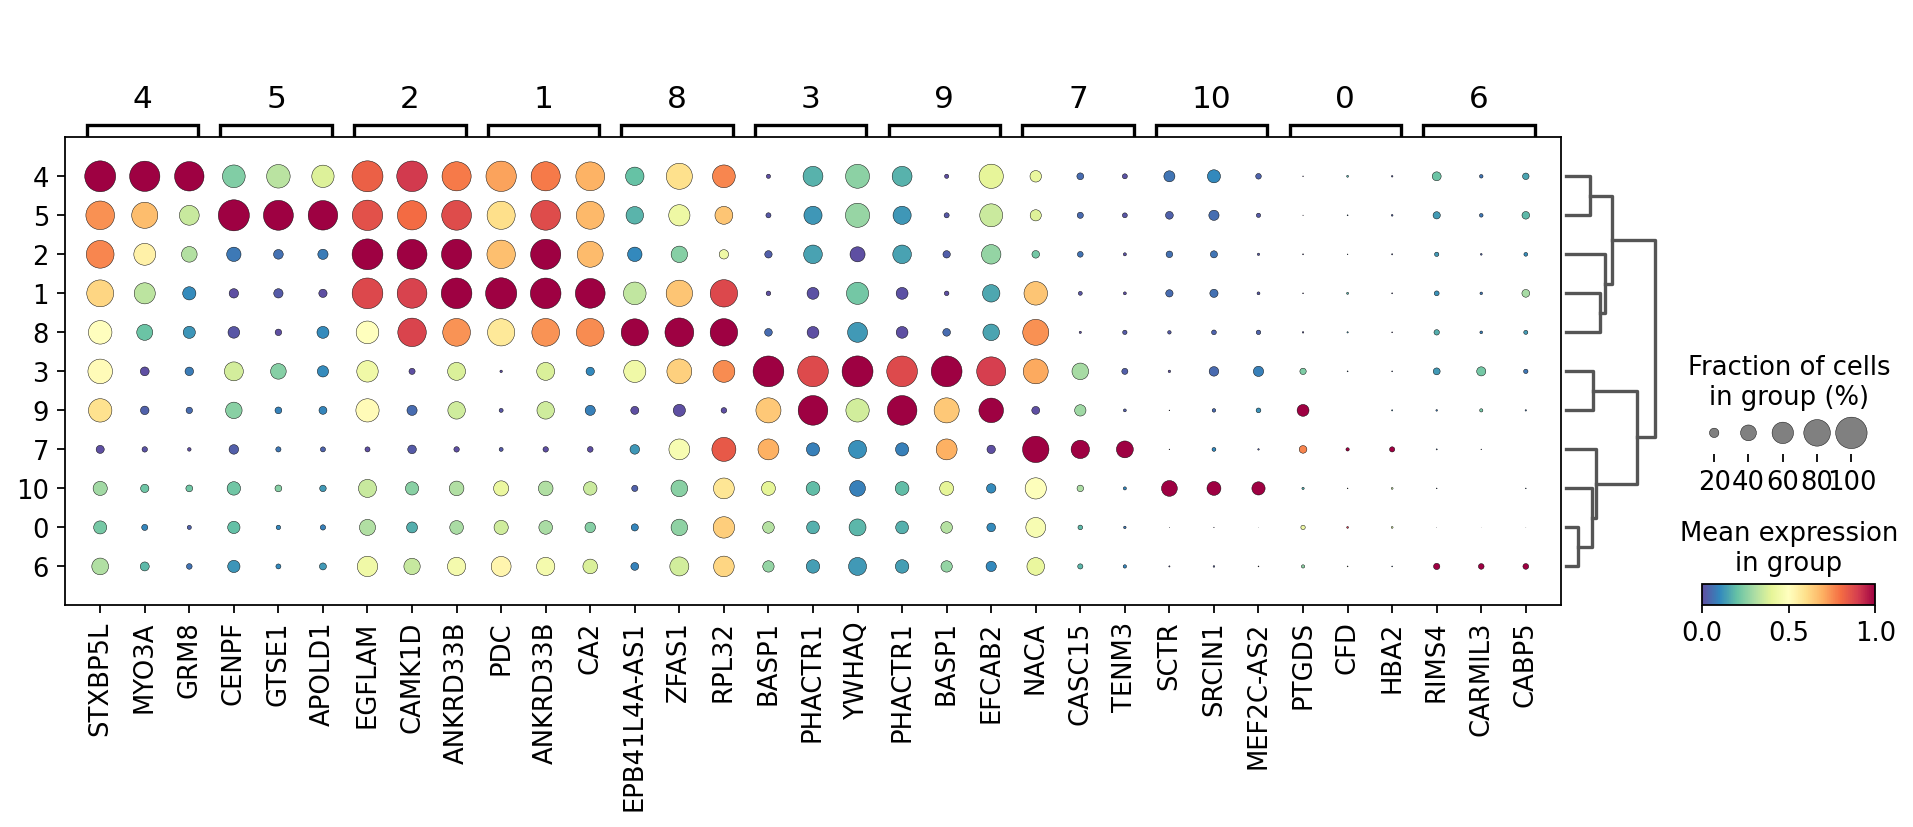

In [20]:
sc.pl.rank_genes_groups_dotplot(adata,groupby='leiden',
                                cmap='Spectral_r',
                                standard_scale='var',n_genes=3)

**finished identifying marker genes by COSG**


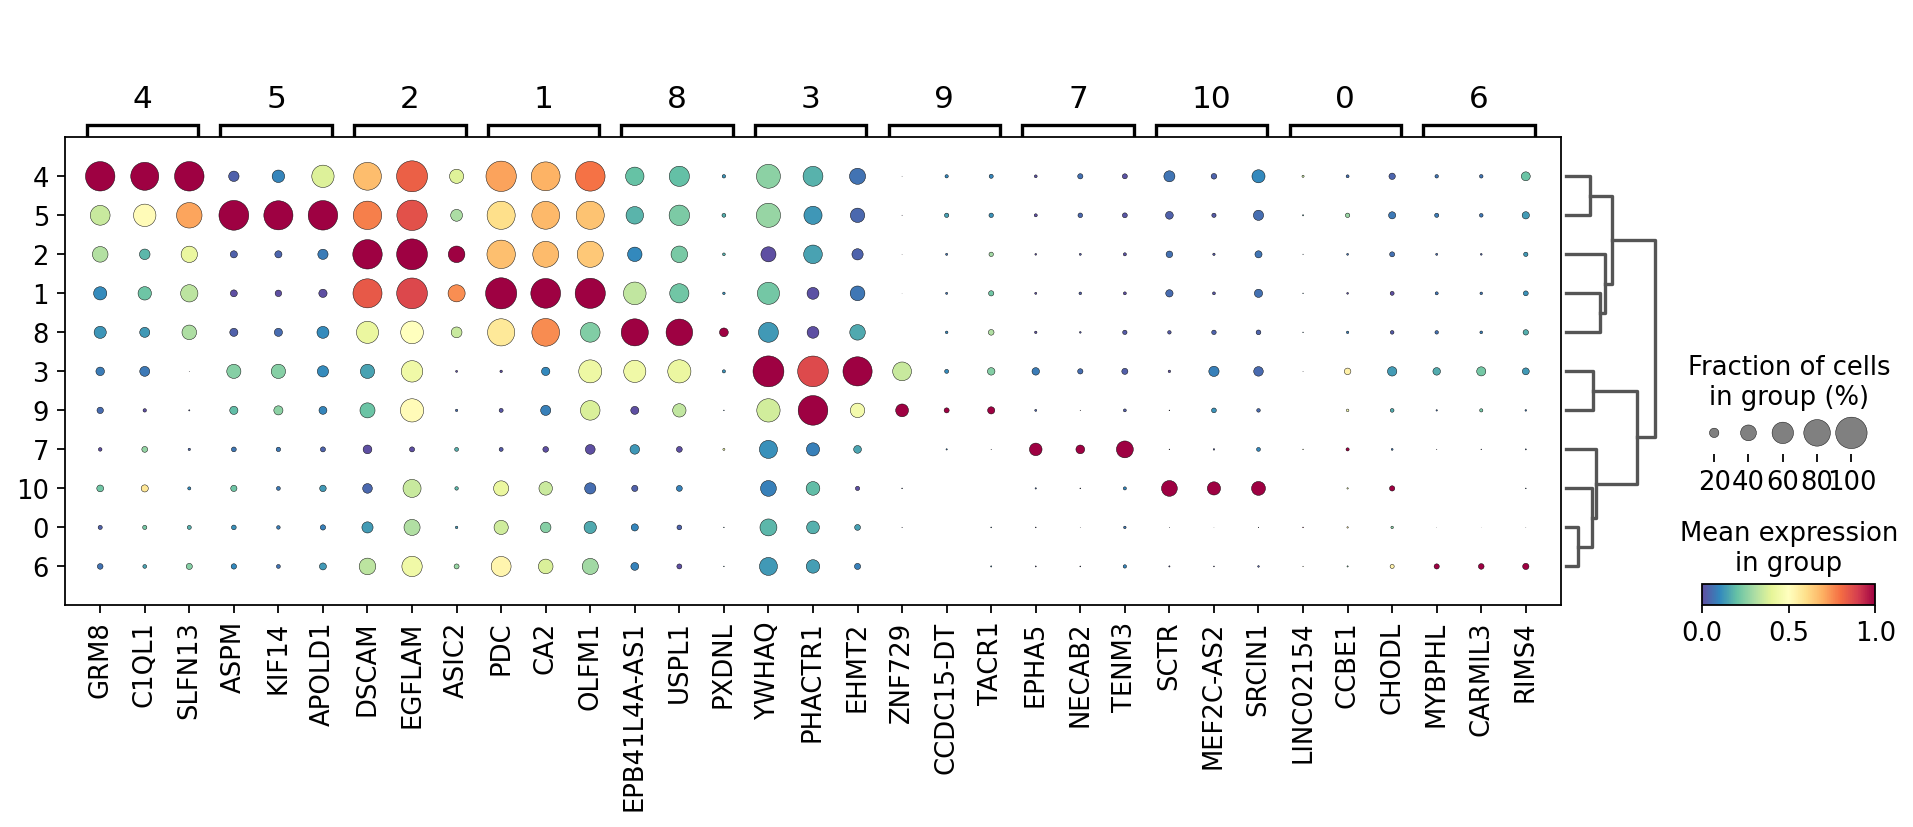

In [21]:
Pyomic.single.cosg(adata, key_added='cosg', groupby='leiden',n_genes_user=10)
sc.pl.rank_genes_groups_dotplot(adata,groupby='leiden',
                                cmap='Spectral_r',key='cosg',
                                standard_scale='var',n_genes=3)

我们去除核糖体基因，使得分析后的文件更加干净

In [27]:
adata=adata[:,[i for i in adata.var.index if 'RPS' not in i]]
adata=adata[:,[i for i in adata.var.index if 'RPL' not in i]]

我们利用marker基因的功能进行注释

In [50]:
# create a dictionary to map cluster to annotation label
#"Transcription-Chaperone Ribosomal Photoreceptor" or "TCR Photoreceptor" 
cluster2annotation = {
     '0': 'Retinal stem cells',
     '1': 'Rod-Photoreceptor cells',
     '2': 'Middle-Photoreceptor cells',#Germ-cell(Oid)
     '3': 'STER cells',#Germ-cell(Oid)
     '4': 'Cone-Photoreceptor cells',
     '5': 'P-Photoreceptor cells',
     '6': 'Retinal stem cells',
     '7': 'Retinal stem cells',
     '8': 'TCR Photoreceptor cells',
     '9': 'STER cells',
     '10': 'Retinal stem cells',#Germ-cell(Oid)


}
adata.obs['major_celltype1'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

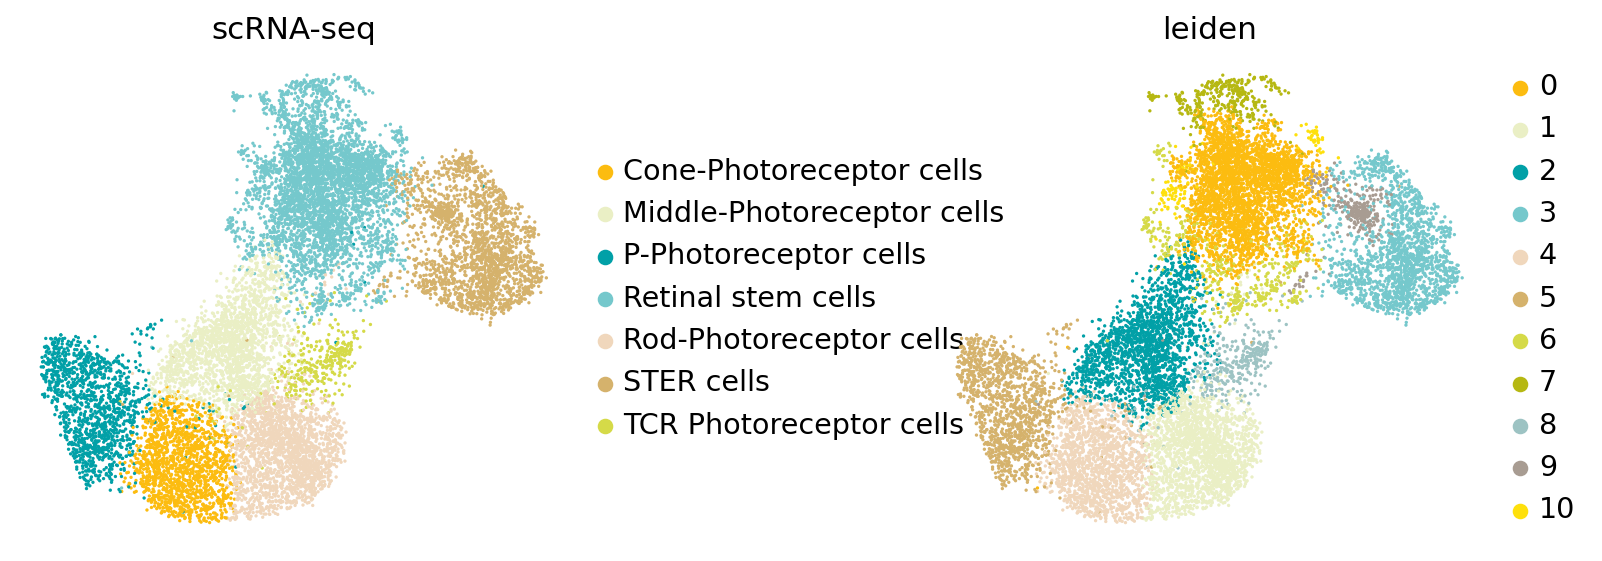

In [51]:
ax=sc.pl.embedding(
    adata,
    basis="X_umap",
    color=['major_celltype1','leiden'],
    title='scRNA-seq',
    frameon=False,
    ncols=3,
    #save='_figure1_celltype.png',
    return_fig=True,
    wspace=0.5,
    show=False,
    palette=sc_color[16:],
)

    using 'X_pca' with n_pcs = 100
Storing dendrogram info using `.uns['dendrogram_major_celltype1']`
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


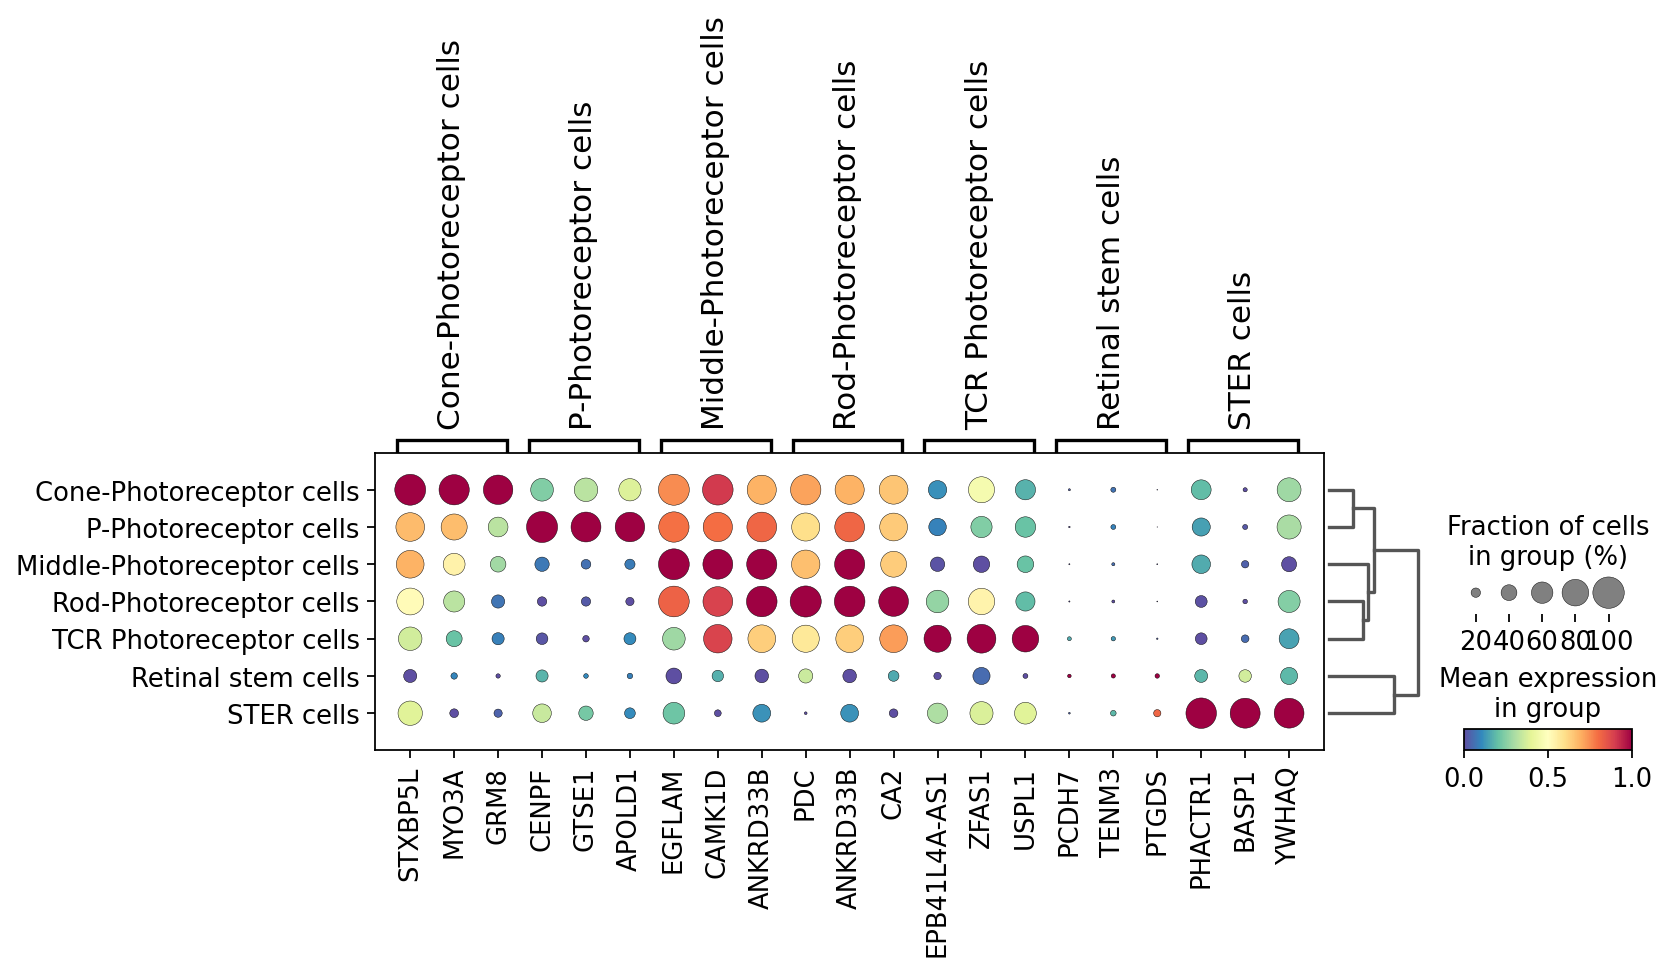

In [52]:
sc.tl.dendrogram(adata,'major_celltype1')
sc.tl.rank_genes_groups(adata, 'major_celltype1', method='t-test',use_raw=False,n_genes=50)
sc.pl.rank_genes_groups_dotplot(adata,groupby='major_celltype1',
                                cmap='Spectral_r',
                                standard_scale='var',n_genes=3)

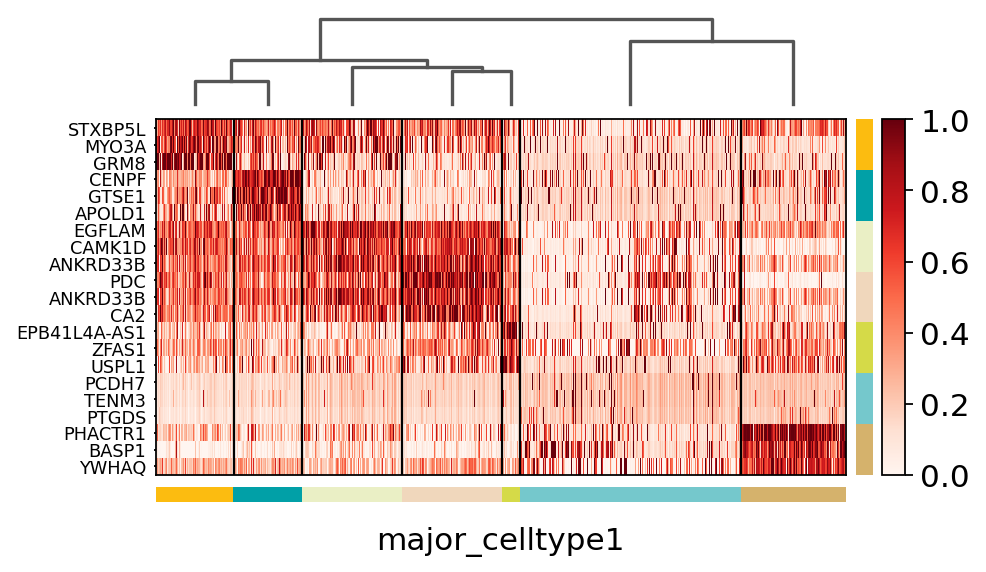

In [53]:
ax=sc.pl.rank_genes_groups_heatmap(adata, n_genes=3, use_raw=False, 
                                swap_axes=True, standard_scale='obs',
                                cmap='Reds',  figsize=(6,4), show=False)
ax['heatmap_ax'].set_yticklabels(ax['heatmap_ax'].get_yticklabels(),fontsize=8)
ax['groupby_ax'].set_xticklabels([])
plt.savefig(current_path+'result/analysis3/P_marker.png',dpi=300,bbox_inches='tight')

In [54]:
adata.write_h5ad(current_path+'data/analysis3/photo_anno.h5ad',compression='gzip')

## 3. pyVIA轨迹推断

当 scRNA-velocity 可用时，它可用于指导轨迹推断和自动化初始状态预测。然而，由于 RNA 速度可能会被 (Bergen 2021) 表达增强、可变转录率和仅限于稳态种群的数据捕获范围误导，为了避免误差，我们结合pyVIA进行进一步地推断识别。

### 3.1 初始化模型

模型参数的具体意义请自行查阅文档：https://pyvia.readthedocs.io/en/latest/ViaJupyter_Pancreas_RNAvelocity.html

2023-03-13 04:41:24.414173	Running VIA over input data of 13315 (samples) x 100 (features)
2023-03-13 04:41:24.414212	Knngraph has 20 neighbors
2023-03-13 04:41:26.665899	Finished global pruning of 20-knn graph used for clustering at level of 0.15. Kept 42.7 % of edges. 
2023-03-13 04:41:26.707485	Number of connected components used for clustergraph  is 1
2023-03-13 04:41:28.581401	Commencing community detection
2023-03-13 04:41:28.775027	Finished running Leiden algorithm. Found 245 clusters.
2023-03-13 04:41:28.778095	Merging 216 very small clusters (<10)
2023-03-13 04:41:28.781018	Finished detecting communities. Found 29 communities
2023-03-13 04:41:28.781762	Making cluster graph. Global cluster graph pruning level: 0.5
2023-03-13 04:41:28.804139	Graph has 1 connected components before pruning
2023-03-13 04:41:28.806116	Graph has 1 connected components after pruning
2023-03-13 04:41:28.806271	Graph has 1 connected components after reconnecting
2023-03-13 04:41:28.806853	0.0% links tr

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


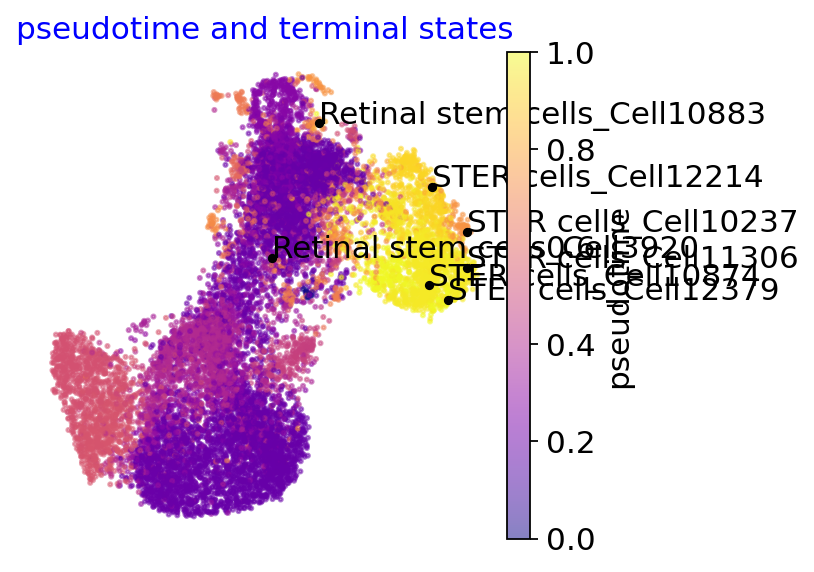

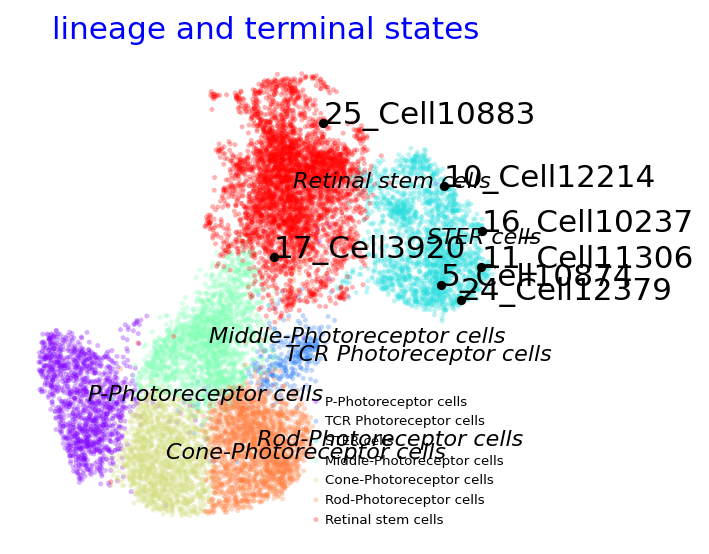

2023-03-13 04:41:38.161372	Time elapsed 12.4 seconds


In [55]:
jac_std_global = 0.15 #(smaller values increase granularity of clusters)
n_pcs = 100
knn = 20
cluster_graph_pruning_std = 0.5 #(smaller values remove more edges in the cluster graph)
v0_toobig = .3 #(clusters that form more than 30% of entire population will be re-clustered)
root = None # No user-defined guidance for finding initial state [63] is a suitable root cell index
dataset = ''
random_seed = 42
velo_weight=0.5 #weight given to velocity matrix from scvelo. 1-velo_weight is assigned to gene-gene kernel
embedding = adata.obsm['X_umap'][:, 0:2]
true_label = adata.obs['major_celltype1'].tolist()
velocity_matrix=adata.layers['velocity']
gene_matrix=adata.X
pca_loadings = adata.varm['PCs'] # this is optional and offers slight adjustment of the locations of cells based on velocity

#impute genes we want to use in gene-trends later
#gene_list_magic_short = ['Sst','Ins1','Ins2','Gcg','Ghrl']
#df_ = pd.DataFrame(adata.X.todense())
#df_.columns = [i for i in adata.var_names]
#df_ = df_[gene_list_magic_short]


v0 = via.VIA(adata.obsm['X_pca'][:, 0:n_pcs], true_label, jac_std_global=jac_std_global, dist_std_local=1, knn=knn,
             too_big_factor=v0_toobig, root_user=root, dataset=dataset, random_seed=random_seed,
           is_coarse=True, preserve_disconnected=True, pseudotime_threshold_TS=50,
             cluster_graph_pruning_std=cluster_graph_pruning_std,
             piegraph_arrow_head_width=0.15,embedding = embedding,
             piegraph_edgeweight_scalingfactor=2.5, velocity_matrix=velocity_matrix,
                    gene_matrix=gene_matrix, velo_weight=velo_weight,  edgebundle_pruning_twice=False, edgebundle_pruning=0.15, pca_loadings = adata.varm['PCs']) # pca_loadings is optional #edge_bundling_twice = True would remove more of the edges
v0.run_VIA()

Text(0.5, 1.0, 'Pseudotime')

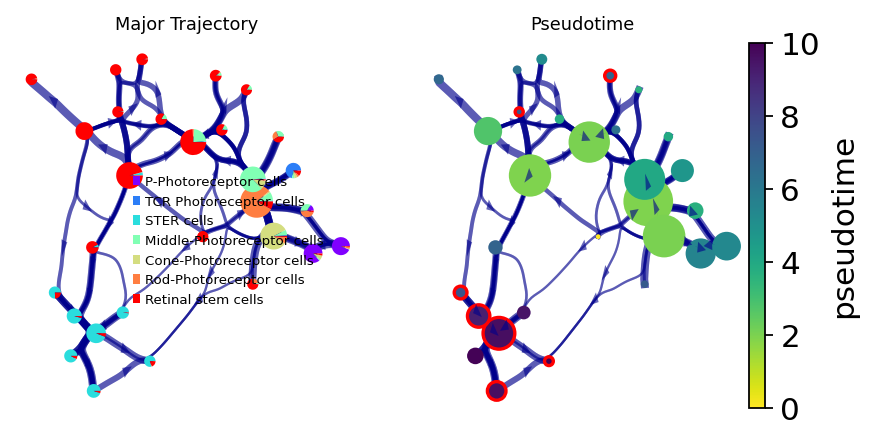

In [56]:
fig, ax, ax1 = via.draw_piechart_graph(via_object=v0,dpi=80,
                                       ax_text=False,fontsize=4)
fig.set_size_inches(6,3)
ax.set_title('Major Trajectory',fontsize=8)
#ax.legend(bbox_to_anchor=(0.5, 0), loc='upper center', borderaxespad=0.,fontsize=8)
ax1.set_title('Pseudotime',fontsize=8)

### 3.2 可视化分化轨迹比例

这里我们使用我们最开始自定义的函数完成

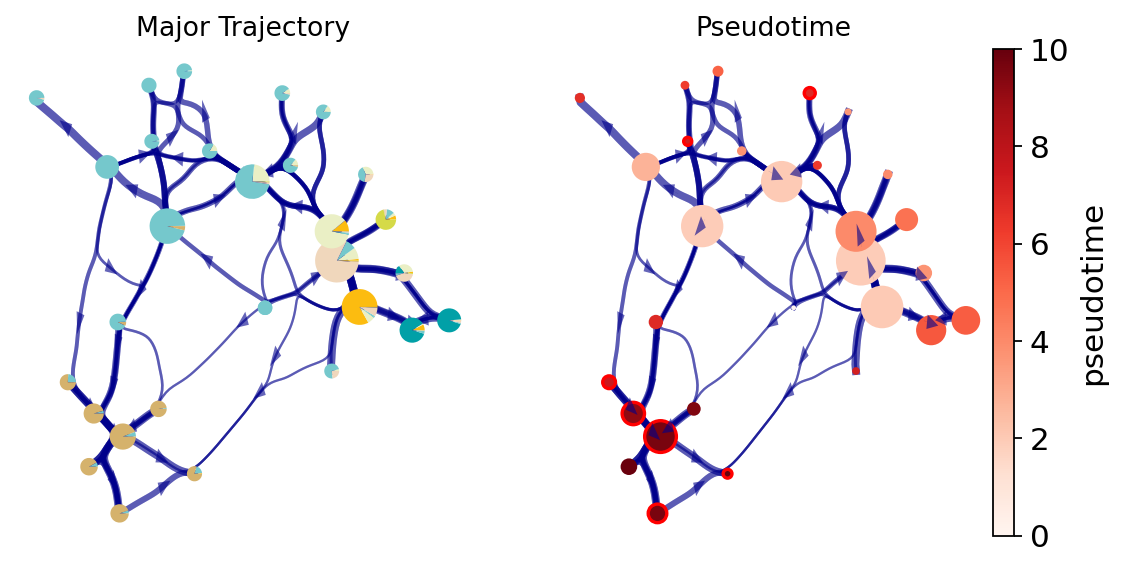

In [57]:
fig, ax, ax1 = draw_piechart_graph(adata=adata,clusters='major_celltype1',
                                   via_object=v0,cmap='Reds',dpi=80,
                                   show_legend=False,ax_text=False,fontsize=4)
fig.set_size_inches(8,4)
ax.set_title('Major Trajectory',fontsize=12)
#ax.legend(bbox_to_anchor=(0.5, 0), loc='upper center', borderaxespad=0.,fontsize=8)
ax1.set_title('Pseudotime',fontsize=12)

plt.savefig(current_path+'result/analysis3/P_tr.png',dpi=300,bbox_inches='tight')

### 3.3 拟时序可视化

我们使用pyVIA重新恢复了拟时序时间，所以这里重新赋值给adata并可视化

In [58]:
from cellrank.tl.kernels import PseudotimeKernel
adata.obs['pt']=v0.single_cell_pt_markov
ptk=PseudotimeKernel(adata,time_key='pt')

In [59]:
ptk.compute_transition_matrix()
ptk.compute_projection(basis='umap')

Computing transition matrix based on `pt`


100%|██████████| 13315/13315 [00:03<00:00, 4181.79cell/s]


    Finish (0:00:11)
Projecting transition matrix onto `umap`
Adding `adata.obsm['T_fwd_umap']`
    Finish (0:00:03)


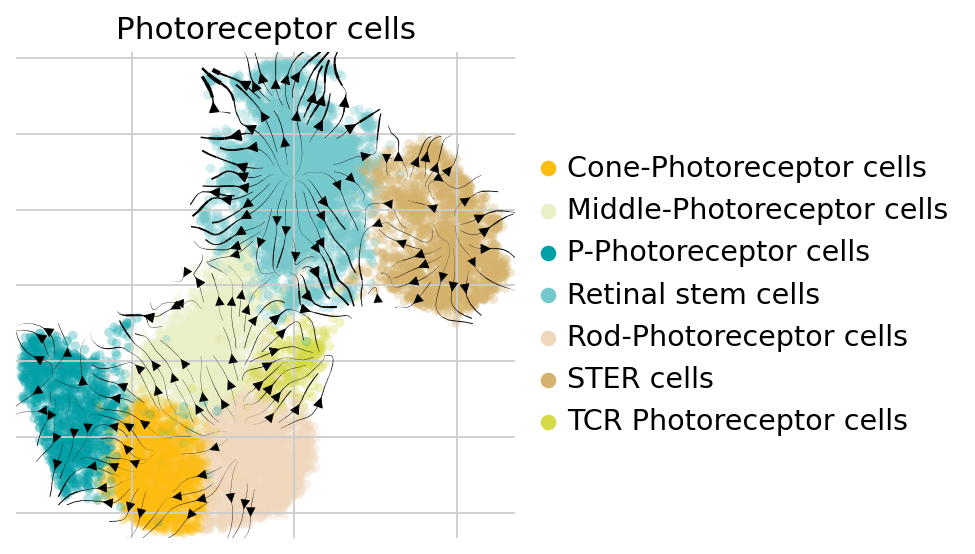

In [60]:
scv.pl.velocity_embedding_stream(adata, vkey='T_fwd',color=['major_celltype1',],
                                 title='Photoreceptor cells',
                                 legend_loc='right margin',
                                legend_align_text='y',show=False,)
plt.savefig(current_path+'result/analysis3/P_celltype.png',dpi=300,bbox_inches='tight')

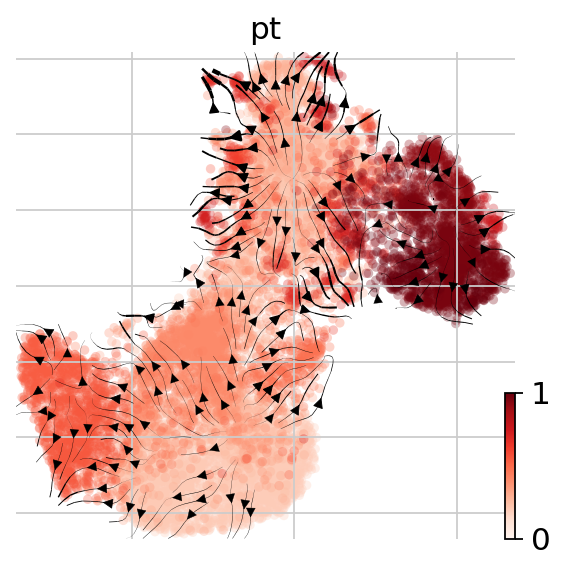

In [61]:
scv.pl.velocity_embedding_stream(adata, vkey='T_fwd',color=['pt',],
                                 title='pt',
                                 legend_loc='right margin',cmap='Reds',
                                legend_align_text='y',show=False,)
plt.savefig(current_path+'result/analysis3/P_pt.png',dpi=300,bbox_inches='tight')

### 3.4 时序依赖基因可视化

在这里我们将拟时序相关的基因进行排序可视化，筛选标准为`adata.var['fit_likelihood']>0.2`

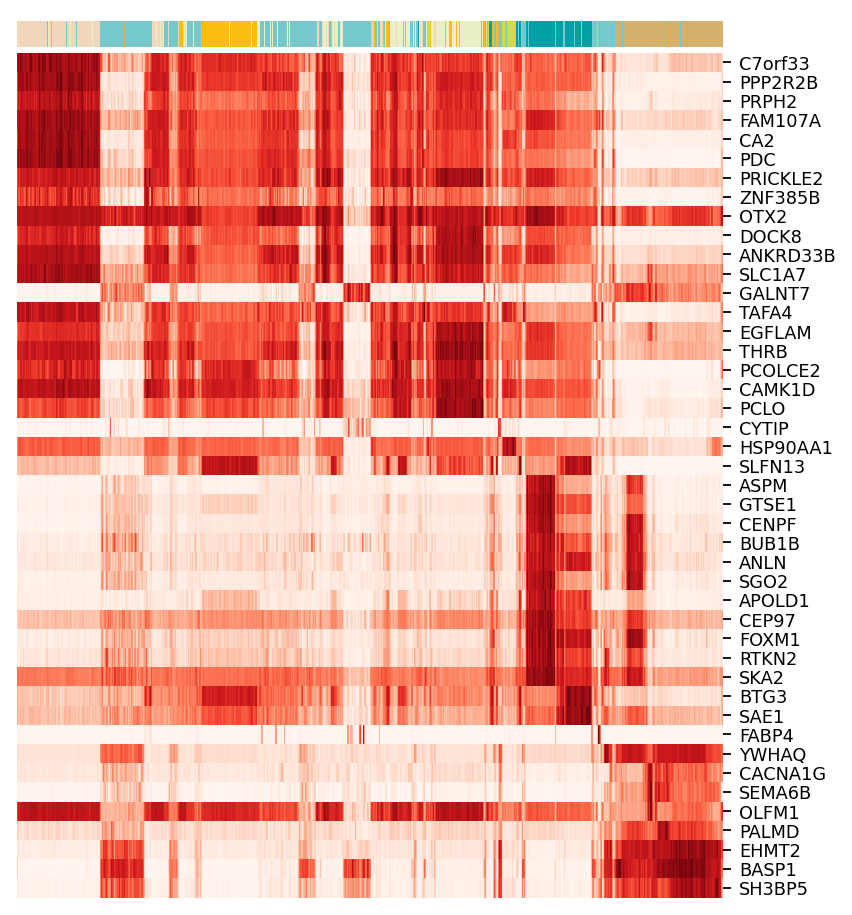

In [65]:
top_genes_neg = adata.var.loc[adata.var['fit_likelihood']>0.2].index
a=scv.pl.heatmap(adata, var_names=top_genes_neg, sortby='pt', col_color=['major_celltype1'],
               n_convolve=30,figsize=(6,6),yticklabels=True,show=False,color_map='Reds')
a.ax_heatmap.yaxis.set_tick_params(labelsize=8)
a.ax_col_colors.yaxis.set_ticks([1.5],['major_celltype1'],ha='left')
a.ax_col_colors.yaxis.tick_right()
labels=a.ax_col_colors.yaxis.get_ticklabels()
plt.setp(labels, fontsize=8)
plt.savefig(current_path+'result/analysis3/P_time_gene.png',dpi=300,bbox_inches='tight')

我们可以与细胞亚型的marker基因取交集，进行进一步挖掘

In [63]:
target_dict_all={}
for ad,name in zip([adata],['RNA']):
    celltype=[(i, 'O') for i in ad.uns['rank_genes_groups']['names'].dtype.names]
    target_dict={}
    target_pd=pd.DataFrame()
    for i in range(len(celltype)):
        cellmarker=[]
        for k in range(50):
            #rank_genes_groups
            cellmarker.append(ad.uns['rank_genes_groups']['names'][k][i])
        #print(cellmarker[0])
        target_pd[celltype[i][0]]=cellmarker
        #ret_target=list(set(cellmarker) & set(rnk_gene))
        target_dict[celltype[i][0]]=cellmarker

    target_dict.keys(),len(cellmarker)
    target_dict_all[name]=target_dict

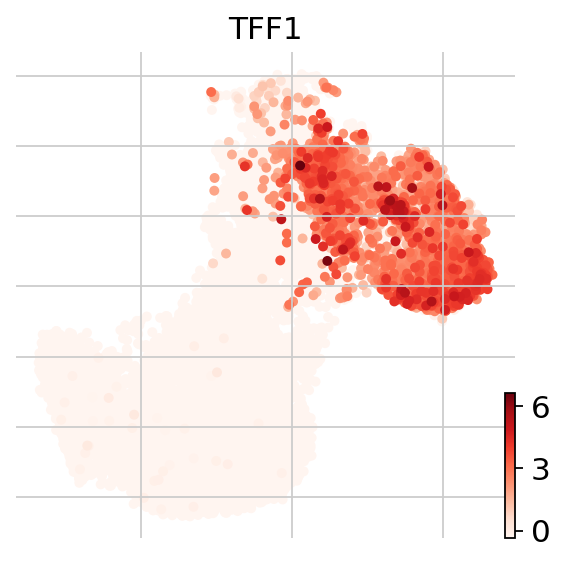

In [70]:
scv.pl.scatter(adata, color='TFF1', color_map='Reds', size=80)

我们也可以利用动力学模型寻找最高相关的基因

In [66]:
scv.tl.rank_dynamical_genes(adata, groupby='major_celltype1')
df = scv.get_df(adata, 'rank_dynamical_genes/names')
df.head(5)

ranking genes by cluster-specific likelihoods
    finished (0:00:01) --> added 
    'rank_dynamical_genes', sorted scores by group ids (adata.uns)


Cone-Photoreceptor cells Middle-Photoreceptor cells P-Photoreceptor cells  \
0                   CAMK1D                     CAMK1D                 DOCK8   
1                 ANKRD33B                   ANKRD33B                CAMK1D   
2                    DOCK8                   PRICKLE2              ANKRD33B   
3                   EGFLAM                    FAM107A                  THRB   
4                     THRB                       THRB              PRICKLE2   

  Retinal stem cells Rod-Photoreceptor cells STER cells  \
0            PPP2R2B                  CAMK1D      BASP1   
1              DOCK8                PRICKLE2       OTX2   
2           ANKRD33B                  EGFLAM     SH3BP5   
3             EGFLAM                 FAM107A       SAE1   
4               PCLO                   DOCK8      YWHAQ   

  TCR Photoreceptor cells  
0                  CAMK1D  
1                 FAM107A  
2                   DOCK8  
3                    PCLO  
4                ANKRD33B

黑线对应于估计的“稳态”比率，即处于恒定转录状态的未剪接与剪接 mRNA 丰度的比率。特定基因的 RNA 速度被确定为残差，也就是说，观测值偏离稳态线的程度。正向速度表明，一个基因是上调，这发生在细胞显示较高丰度的未剪接 mRNA 的基因比预期的稳定状态。相反，负速度表明基因下调。

例如，DOCK8 解释了上调的 Retinal stem cells到Rod Photoreceptor cells的方向性

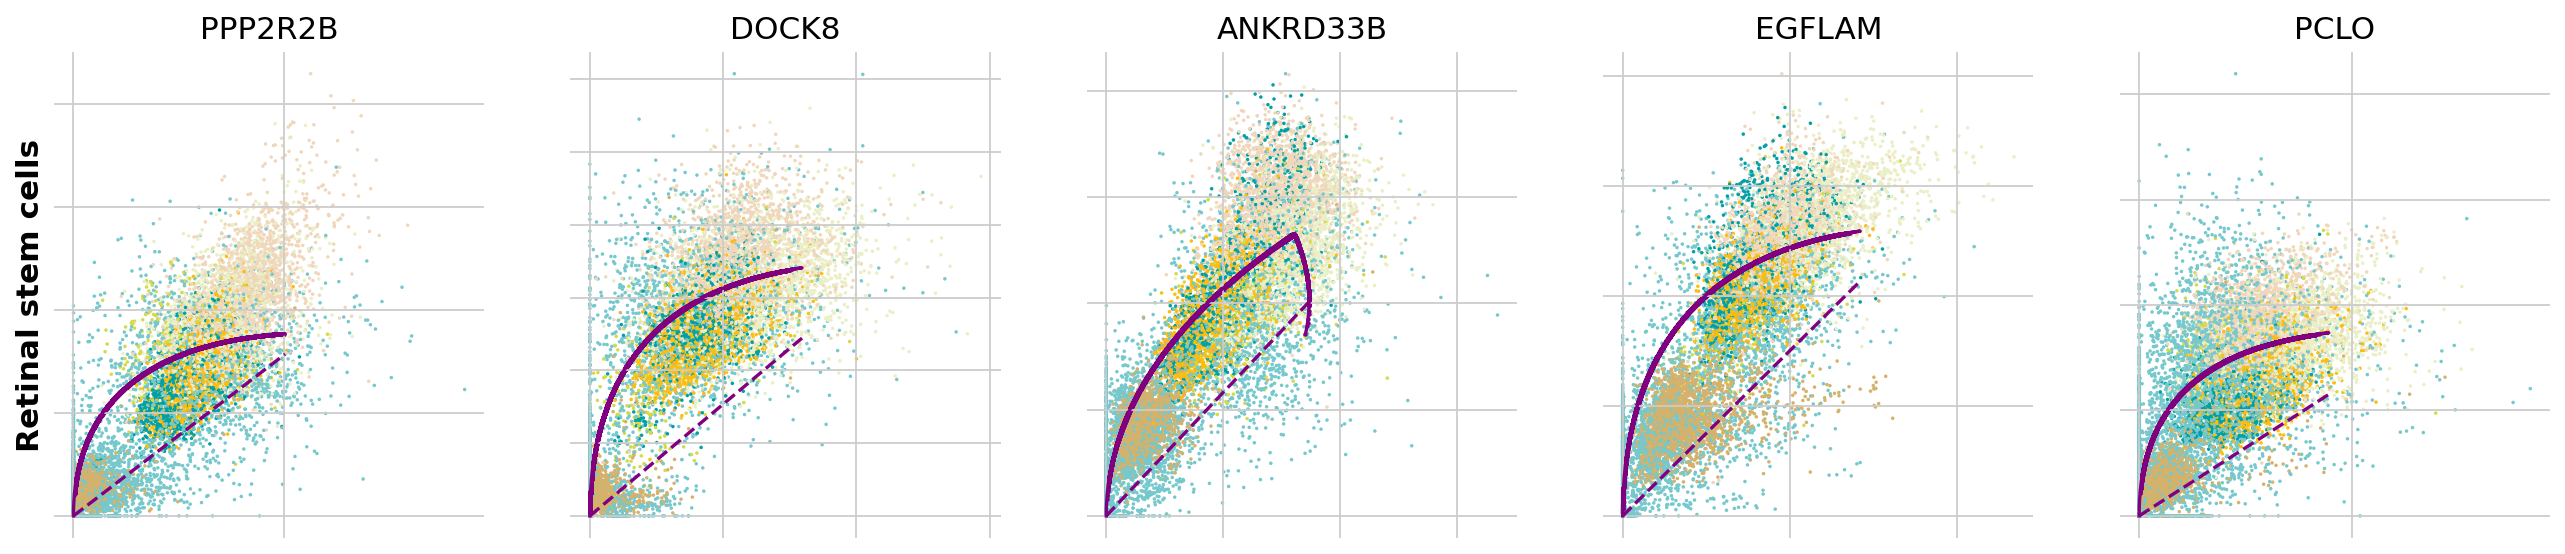

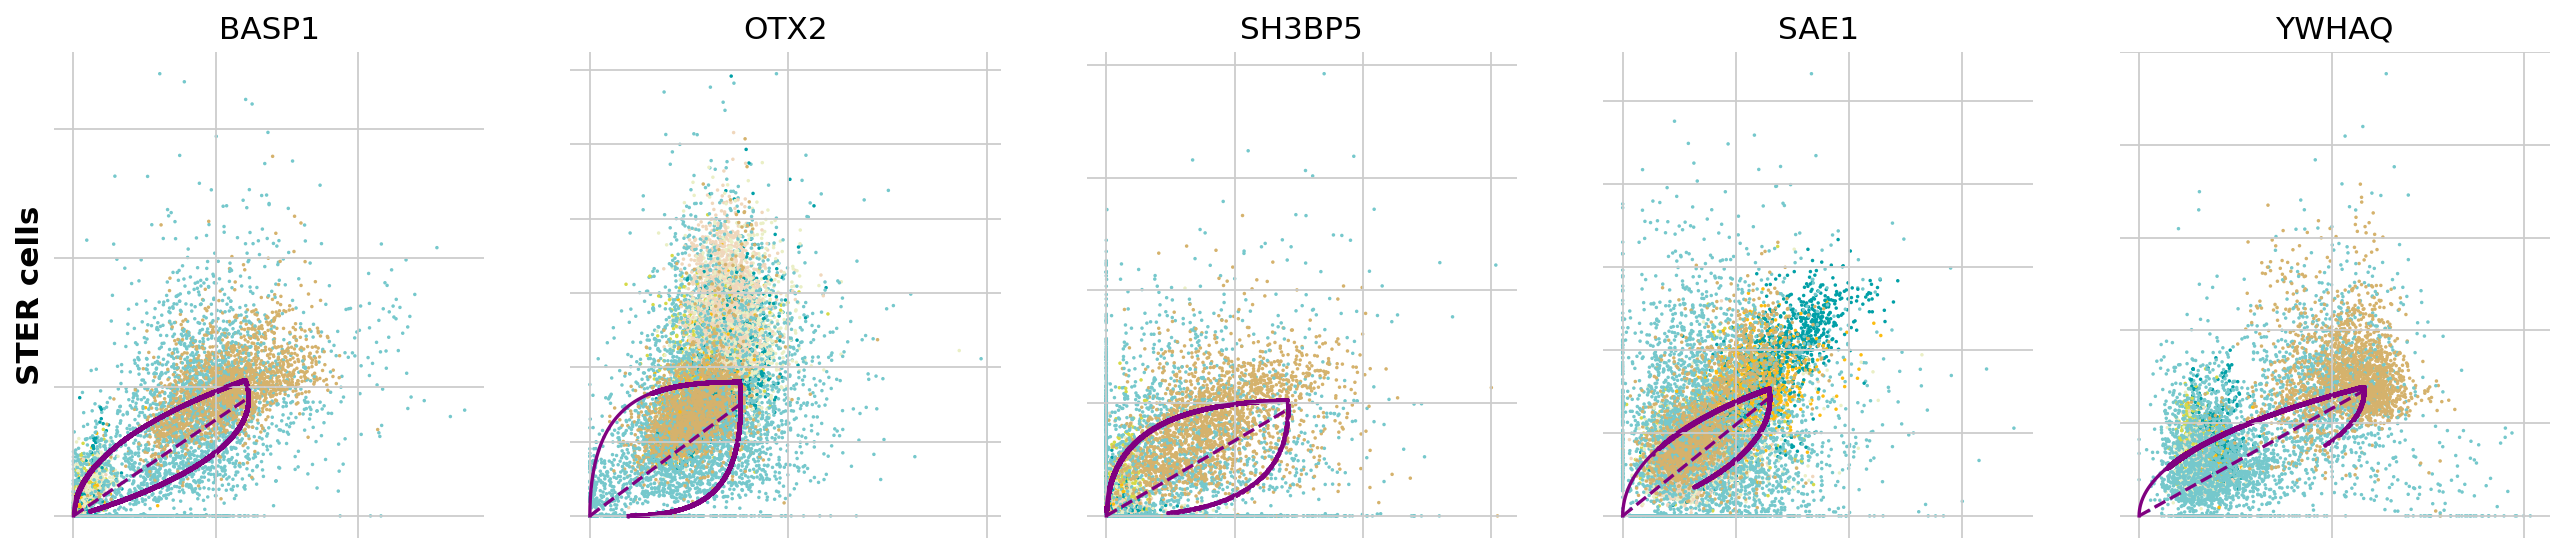

In [67]:
kwargs = dict(frameon=False, size=10, linewidth=1.5,
              )

scv.pl.scatter(adata, df['Retinal stem cells'][:5], color='major_celltype1',ylabel='Retinal stem cells', **kwargs)
scv.pl.scatter(adata, df['STER cells'][:5], color='major_celltype1',ylabel='STER cells', **kwargs)

同理，我们除了画动力学相图外，我们还可以画轨迹上的表达图

shape of transition matrix raised to power 3 (13315, 13315)


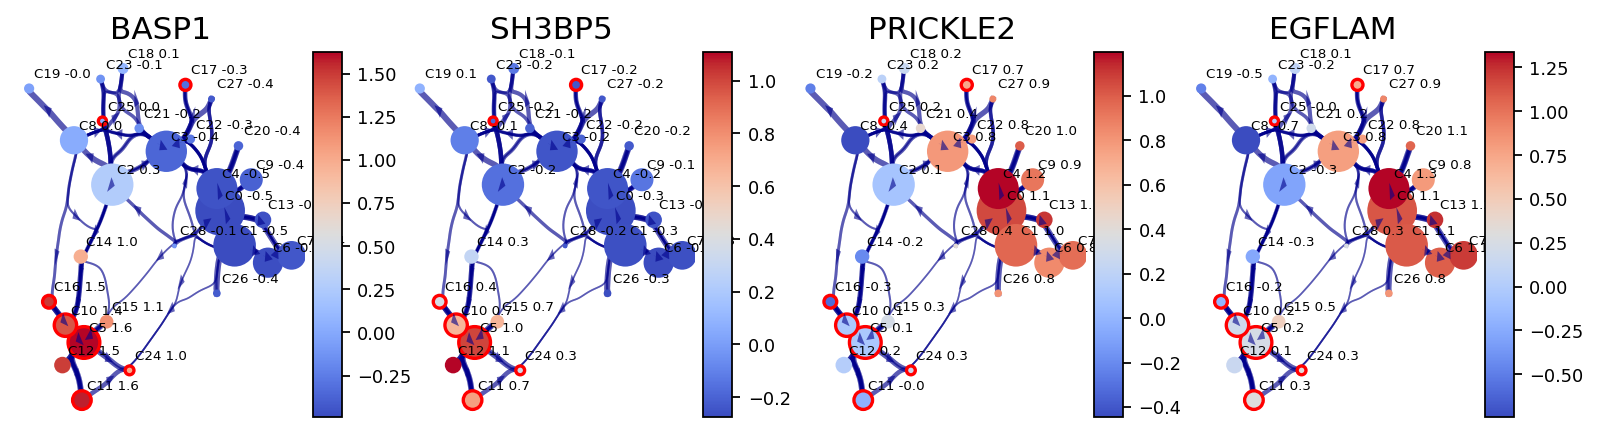

In [76]:
df_ = pd.DataFrame(adata.X)
df_.columns = [i for i in adata.var_names]

gene_list_magic = ['BASP1','SH3BP5','PRICKLE2','EGFLAM']
#gene_list_magic = ['CAMK1D','ANKRD33B','PPP2R2B','DOCK8']
df_magic = v0.do_impute(df_, magic_steps=3, gene_list=gene_list_magic)
df_magic['parc'] = v0.labels
df_magic_cluster = df_magic.groupby('parc', as_index=True).mean()

fig, axs = via.draw_clustergraph(via_object=v0, type_data='gene', 
                                 gene_exp=df_magic_cluster, gene_list=gene_list_magic, arrow_head=0.1)
fig.set_size_inches(12,3)
fig.savefig(current_path+'result/analysis3/P_{}.png'.format(str(gene_list_magic)),dpi=300,bbox_inches='tight')

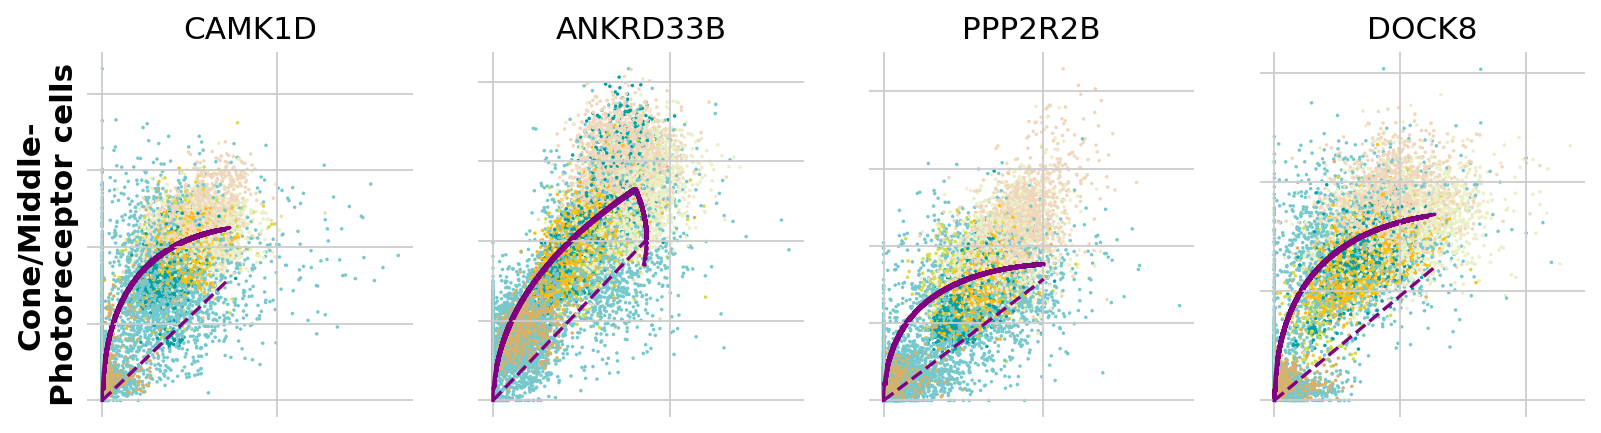

In [81]:
#fig, ax = plt.subplots(figsize=(3,3))
gene_list_magic = ['CAMK1D','ANKRD33B','PPP2R2B','DOCK8']
scv.pl.scatter(adata, gene_list_magic, color='major_celltype1',
               ylabel='Cone/Middle-\nPhotoreceptor cells', show=False,figsize=(3,3),
               **kwargs)
plt.savefig(current_path+'result/analysis3/P_v_{}.png'.format(str(gene_list_magic)),dpi=300,bbox_inches='tight')

## 4. 差异表达分析

我们需要探究的是视网膜退化的机理，已知2年的数据里没有视网膜细胞，4个月的有，所以非常自然而然地想到，我们可以用2年与4个月的进行一下差异表达分析。寻找2年的时候表达下调的基因，以及关闭的染色体区域

### 4.1 读取数据

In [77]:
rna_raw=rna.raw.to_adata()
rna_raw

AnnData object with n_obs × n_vars = 20105 × 21705
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'Tissue', 'Developmental_Stage', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'domain', 'leiden', 'balancing_weight', 'n_counts', 'major_celltype', 'obs_index_raw'
    var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'End', 'Start', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'ID', 'copy_num_ID', 'coverage', 'db_xref', 'extra_copy_number', 'gbkey', 'gene', 'gene_biotype', 'gene_name', 'dell'
    uns: 'Developmental_Stage_colors', '__scglue__', 'cosg', 'dendrogram_leiden', 'dendrogram_major_celltype', 'hvg', 'leiden', 

In [82]:
from scipy  import stats,sparse
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection
#由于数据已经对数化过了，我们直接做减法就好，这里封装了一个函数
def scdeg(adata1,adata2):
    mean1=adata1.X.mean(axis=0)
    mean2=adata2.X.mean(axis=0)
    
    if sparse.issparse(adata1.X):
        fold=np.array(adata1.X.mean(axis=0)-adata2.X.mean(axis=0))[0]
        #fold=fold[0]
        #log2fold=np.log2(fold)
        ttest = stats.ttest_ind(adata1[:,:].X.toarray(),adata2[:,:].X.toarray())
    else:
        fold=adata1.X.mean(axis=0)-adata2.X.mean(axis=0)
        #log2fold=np.log2(fold)
        ttest = stats.ttest_ind(adata1[:,:].X,adata2[:,:].X)
    pvalue=ttest.pvalue
    
    res=pd.DataFrame(index=adata1.var.index)
    res['log2FC']=fold
    res['pvalue']=pvalue
    return res

### 4.2 scRNA-seq的差异表达分析

这里我们选取0.25作为阈值，详细的选取方式我们可以看`plt.hist(deg_r['log2FC-rna'])`观察一下数据分布，就知道阈值卡多少合适了

In [83]:
deg_r=scdeg(rna_raw[(rna_raw.obs['Developmental_Stage']=='Retinoblastoma_2years')],
            rna_raw[(rna_raw.obs['Developmental_Stage']=='Retinoblastoma_4months')])
deg_r.columns=[i+'-rna' for i in deg_r.columns]
qvalue=fdrcorrection(np.nan_to_num(np.array(deg_r['pvalue-rna']),0), alpha=0.05, method='indep', is_sorted=False)
deg_r['qvalue-rna']=qvalue[1]

In [84]:
deg_r['sig-rna']='normal'
deg_r.loc[((deg_r['log2FC-rna']>0.25)&(deg_r['qvalue-rna']<0.05)),'sig-rna']='up'
deg_r.loc[((deg_r['log2FC-rna']<-0.25)&(deg_r['qvalue-rna']<0.05)),'sig-rna']='down'
#deg_r['log(padj)']=-np.log10(qvalue[1]+0.000000001)
deg_r.head()

log2FC-rna    pvalue-rna    qvalue-rna sig-rna
LINC01409   -0.149853  1.461657e-25  6.679002e-25  normal
FAM87B       0.005374  7.098221e-01  7.546379e-01  normal
LINC01128   -0.200661  2.522337e-44  1.763199e-43  normal
LINC00115   -0.011585  4.222098e-01  4.873206e-01  normal
FAM41C      -0.019505  1.755350e-01  2.287044e-01  normal

### 4.3 scATAC-seq的差异表达分析

这里我们选取0.1作为阈值，详细的选取方式我们可以看`plt.hist(deg_a['log2FC-atac'])`观察一下数据分布，就知道阈值卡多少合适了

In [ ]:
import mudata
mdata=mudata.read(current_path+'data/analysis1/muatac_anno.h5mu')

In [88]:
act=mdata['act']

In [89]:
deg_a=scdeg(act[(act.obs['Developmental_Stage']=='Retinoblastoma_2years')],
            act[(act.obs['Developmental_Stage']=='Retinoblastoma_4months')])
deg_a.columns=[i+'-atac' for i in deg_a.columns]
qvalue=fdrcorrection(np.nan_to_num(np.array(deg_a['pvalue-atac']),0), alpha=0.05, method='indep', is_sorted=False)
deg_a['qvalue-atac']=qvalue[1]
deg_a.head()
deg_a['sig-atac']='normal'
deg_a.loc[((deg_a['log2FC-atac']>0.1)&(deg_a['qvalue-atac']<0.05)),'sig-atac']='up'
deg_a.loc[((deg_a['log2FC-atac']<-0.1)&(deg_a['qvalue-atac']<0.05)),'sig-atac']='down'
deg_a['log(padj)']=-np.log10(qvalue[1]+0.000000001)
deg_a.head()

log2FC-atac   pvalue-atac   qvalue-atac sig-atac  log(padj)
5S_rRNA       0.858064  0.000000e+00  0.000000e+00       up   9.000000
5_8S_rRNA     0.021489  1.739314e-29  6.475621e-29   normal   9.000000
7SK           0.001902  7.279158e-01  7.470944e-01   normal   0.126625
A1BG          0.327566  0.000000e+00  0.000000e+00       up   9.000000
A1BG_AS1     -0.021407  1.590398e-01  1.766600e-01   normal   0.752862

### 4.4 合并差异分析

我们提取scRNA-seq和scATAC-seq的交集基因，然后合并差异表达的结果为`deg_b`

In [90]:
ret_a_gene=list(set(deg_a.index) & set(deg_r.index))
len(ret_a_gene)

20064

In [92]:
deg_b=pd.concat([deg_r.loc[ret_a_gene],deg_a.loc[ret_a_gene]],join='outer',axis=1)
dif_value=0.25
deg_b['sig']='normal'
deg_b.loc[(deg_b['log2FC-rna']<(0-dif_value)) & (deg_b['log2FC-atac']<-0.1) & (deg_b['qvalue-rna']<0.05) & (deg_b['qvalue-atac']<0.05),'sig']='down-closed'
deg_b.loc[(deg_b['log2FC-rna']>dif_value) & (deg_b['log2FC-atac']>0.1) & (deg_b['qvalue-rna']<0.05) & (deg_b['qvalue-atac']<0.05),'sig']='up-open'

deg_b.loc[(deg_b['log2FC-rna']<(0-dif_value)) & (deg_b['log2FC-atac']>0.1) & (deg_b['qvalue-rna']<0.05) & (deg_b['qvalue-atac']<0.05),'sig']='down-open'
deg_b.loc[(deg_b['log2FC-rna']>dif_value) & (deg_b['log2FC-atac']<-0.1) & (deg_b['qvalue-rna']<0.05) & (deg_b['qvalue-atac']<0.05),'sig']='up-closed'
deg_b['abs(log2FC)']=abs(deg_b['log2FC-rna'])
deg_b.head()

log2FC-rna  pvalue-rna  qvalue-rna sig-rna  log2FC-atac  \
COL25A1     0.327010    0.000000    0.000000      up     0.084055   
SNHG16      0.244119    0.000000    0.000000  normal    -0.010555   
PMS2P7     -0.057388    0.000068    0.000138  normal     0.000438   
SRBD1      -0.014105    0.328043    0.393793  normal     0.116112   
CSPG4P1Y   -0.020896    0.147900    0.197070  normal    -0.008819   

           pvalue-atac   qvalue-atac sig-atac  log(padj)     sig  abs(log2FC)  
COL25A1   5.304795e-06  7.976714e-06   normal   5.098122  normal     0.327010  
SNHG16    5.489793e-01  5.738224e-01   normal   0.241223  normal     0.244119  
PMS2P7    8.730504e-01  8.840788e-01   normal   0.053509  normal     0.057388  
SRBD1     2.091231e-16  5.107926e-16       up   9.000000  normal     0.014105  
CSPG4P1Y  2.924244e-06  4.466717e-06   normal   5.349914  normal     0.020896

log2FC-rna -1.1127944 1.0332584
log2FC-atac -2.77486 5.795437


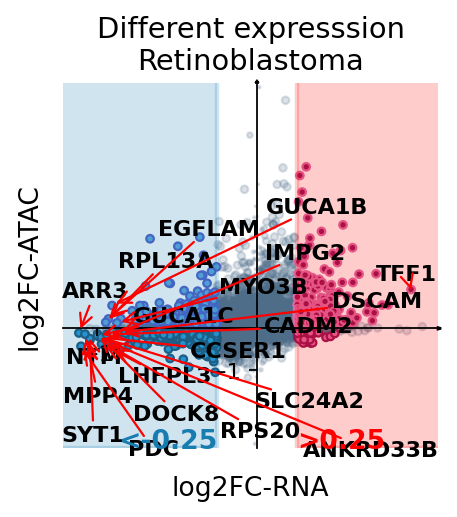

In [93]:
from adjustText import adjust_text
plt.figure(figsize=(3, 3))
plt.scatter(deg_b.loc[deg_b['sig']=='normal']['log2FC-rna'],
            deg_b.loc[deg_b['sig']=='normal']['log2FC-atac'],
            s=-np.log(deg_r.loc[deg_b.loc[deg_b['sig']=='normal'].index]['pvalue-rna']+0.00001),color='#4e6d89',alpha=.2,)

plt.scatter(deg_b.loc[deg_b['sig']=='up-open']['log2FC-rna'],
            deg_b.loc[deg_b['sig']=='up-open']['log2FC-atac'],
            s=-np.log(deg_r.loc[deg_b.loc[deg_b['sig']=='up-open'].index]['pvalue-rna']+0.00001),color=sc_color[15],
           linewidths=1,edgecolors=sc_color[14])

plt.scatter(deg_b.loc[deg_b['sig']=='up-closed']['log2FC-rna'],
            deg_b.loc[deg_b['sig']=='up-closed']['log2FC-atac'],
            s=-np.log(deg_r.loc[deg_b.loc[deg_b['sig']=='up-closed'].index]['pvalue-rna']+0.00001),color=sc_color[14],
           linewidths=1,edgecolors=sc_color[15])

plt.scatter(deg_b.loc[deg_b['sig']=='down-open']['log2FC-rna'],
            deg_b.loc[deg_b['sig']=='down-open']['log2FC-atac'],
            s=-np.log(deg_r.loc[deg_b.loc[deg_b['sig']=='down-open'].index]['pvalue-rna']+0.00001),color='#5ca8dc',
           linewidths=1,edgecolors='#4f61c7')

plt.scatter(deg_b.loc[deg_b['sig']=='down-closed']['log2FC-rna'],
            deg_b.loc[deg_b['sig']=='down-closed']['log2FC-atac'],
            s=-np.log(deg_r.loc[deg_b.loc[deg_b['sig']=='down-closed'].index]['pvalue-rna']+0.00001),color=sc_color[9],
           linewidths=1,edgecolors=sc_color[11])

plot_index=deg_b.loc[deg_b['sig']!='normal'].sort_values('abs(log2FC)',ascending=False).index
texts=[plt.text(deg_b.loc[i,'log2FC-rna'],deg_b.loc[i,'log2FC-atac'],i
        ,fontdict={'size':10,'weight':'bold'}) for i in plot_index[:20]]

adjust_text(texts,only_move={'text': 'xy'},arrowprops=dict(arrowstyle='->', color='red'),)

ax = plt.gca()
# 去掉上、右二侧的边框线
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
 
# 将左侧的y轴，移到x=0的位置
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))
plt.tick_params(labelsize=10)
plt.grid(None)



print('log2FC-rna',deg_b['log2FC-rna'].min(),deg_b['log2FC-rna'].max())
print('log2FC-atac',deg_b['log2FC-atac'].min(),deg_b['log2FC-atac'].max())

plot_xmin=round(deg_b['log2FC-rna'].min(),2)-0.1
plot_xmax=round(deg_b['log2FC-rna'].max(),2)+0.1
plot_ymin=round(deg_b['log2FC-atac'].min(),2)-0.1
plot_ymax=round(deg_b['log2FC-atac'].max(),2)+0.1

plt.xlim(plot_xmin,plot_xmax)
plt.ylim(plot_ymin,plot_ymax)

plt.arrow(0, plot_ymax, 0, 0, width=0.01, color="k", clip_on=False, head_width=0.02, head_length=0.05)
plt.arrow(plot_xmax, 0, 0.001, 0, width=0.01, color="k", clip_on=False, head_width=0.05, head_length=0.02)



plt.gca().add_patch(plt.Rectangle(xy=(0.25,plot_ymin),
width=15, color='red',
height=10,alpha=.2,
fill=True, linewidth=2))

plt.gca().add_patch(plt.Rectangle(xy=(-0.25,plot_ymin),
width=-15, color='#177cb0',
height=10,alpha=.2,
fill=True, linewidth=2))

ax.set_ylabel('log2FC-ATAC', ha='left', y=2, rotation=90, labelpad=75)
ax.set_xlabel('log2FC-RNA', ha='left', y=0, rotation=0, labelpad=50)
plt.text(0.25,plot_ymin,'>0.25',fontsize=12,color='red',fontweight='bold')
plt.text(-0.25,plot_ymin,'<-0.25',fontsize=12,color='#177cb0',ha='right',fontweight='bold')

plt.xlabel('log2FC-RNA',fontsize=12,)
plt.ylabel('log2FC-ATAC',fontsize=12,)
plt.title('Different expresssion\nRetinoblastoma',fontsize=13)

plt.yticks(np.linspace(-1, 0.5, 1))
plt.xticks(np.linspace(-1, 0.5, 1))

plt.savefig(current_path+"result/analysis3/deg_Retinoblastoma.png",dpi=300,bbox_inches = 'tight')

### 4.5 特异性细胞分析

这是我个人比较喜欢的一种分析方法，对差异表达的基因与marker基因做交集，就知道这个基因调控了什么细胞，或者找到了细胞特异性的差异基因。进而更进一步的解释分子机理

In [101]:
sc.tl.dendrogram(adata,'major_celltype1')
adata.uns['log1p']['base']=None
sc.tl.rank_genes_groups(adata, 'major_celltype1', method='t-test',use_raw=False,n_genes=50)
target_dict_all={}
for ad,name in zip([adata],['RNA']):
    celltype=[(i, 'O') for i in ad.uns['rank_genes_groups']['names'].dtype.names]
    target_dict={}
    target_pd=pd.DataFrame()
    for i in range(len(celltype)):
        cellmarker=[]
        for k in range(20):
            #rank_genes_groups
            cellmarker.append(ad.uns['rank_genes_groups']['names'][k][i])
        #print(cellmarker[0])
        target_pd[celltype[i][0]]=cellmarker
        #ret_target=list(set(cellmarker) & set(rnk_gene))
        target_dict[celltype[i][0]]=cellmarker

    target_dict.keys(),len(cellmarker)
    target_dict_all[name]=target_dict

    using 'X_pca' with n_pcs = 100
Storing dendrogram info using `.uns['dendrogram_major_celltype1']`
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [102]:
for celltype in target_dict_all['RNA'].keys():
    ret_g=list(set(deg_b.loc[deg_b['sig']=='down-closed'].index) & set(target_dict_all['RNA'][celltype]))
    print(celltype,ret_g)

Cone-Photoreceptor cells ['PDC', 'GRM8']
Middle-Photoreceptor cells ['DOCK8', 'DSCAM', 'ANKRD33B']
P-Photoreceptor cells []
Retinal stem cells []
Rod-Photoreceptor cells ['DOCK8', 'DSCAM', 'SLC38A5', 'PDC', 'ANKRD33B']
STER cells []
TCR Photoreceptor cells ['TAFA4']


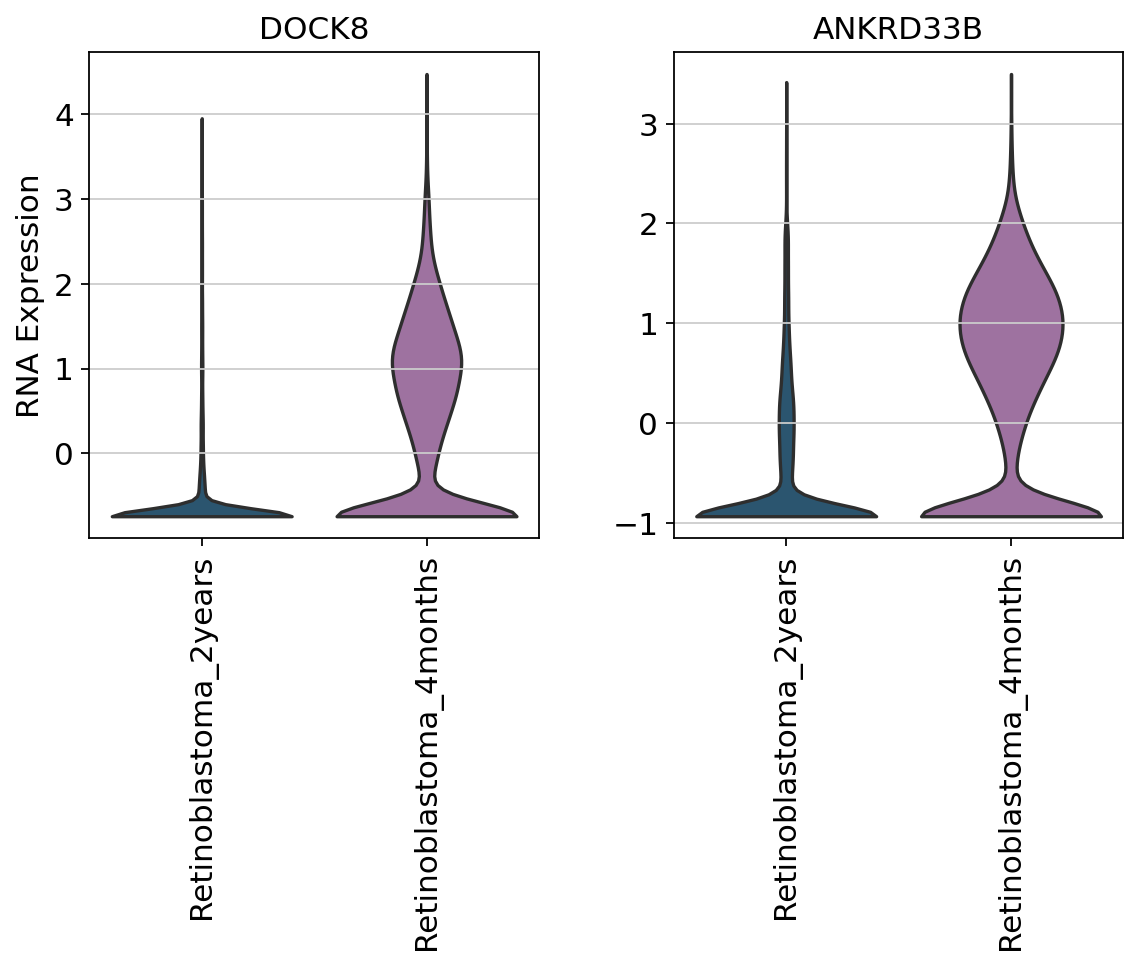

In [112]:
ax=sc.pl.violin(rna_raw, ['DOCK8','ANKRD33B'], groupby='Developmental_Stage',fig_size=(2,2),
             stripplot=False, jitter=0.2, multi_panel=False,show=False)
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=90)
ax[0].set_xlabel('')
ax[0].set_title('DOCK8')
ax[0].set_ylabel('RNA Expression')
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90)
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].set_title('ANKRD33B')
plt.savefig(current_path+'result/analysis3/rna_violin.png',dpi=300,bbox_inches='tight')

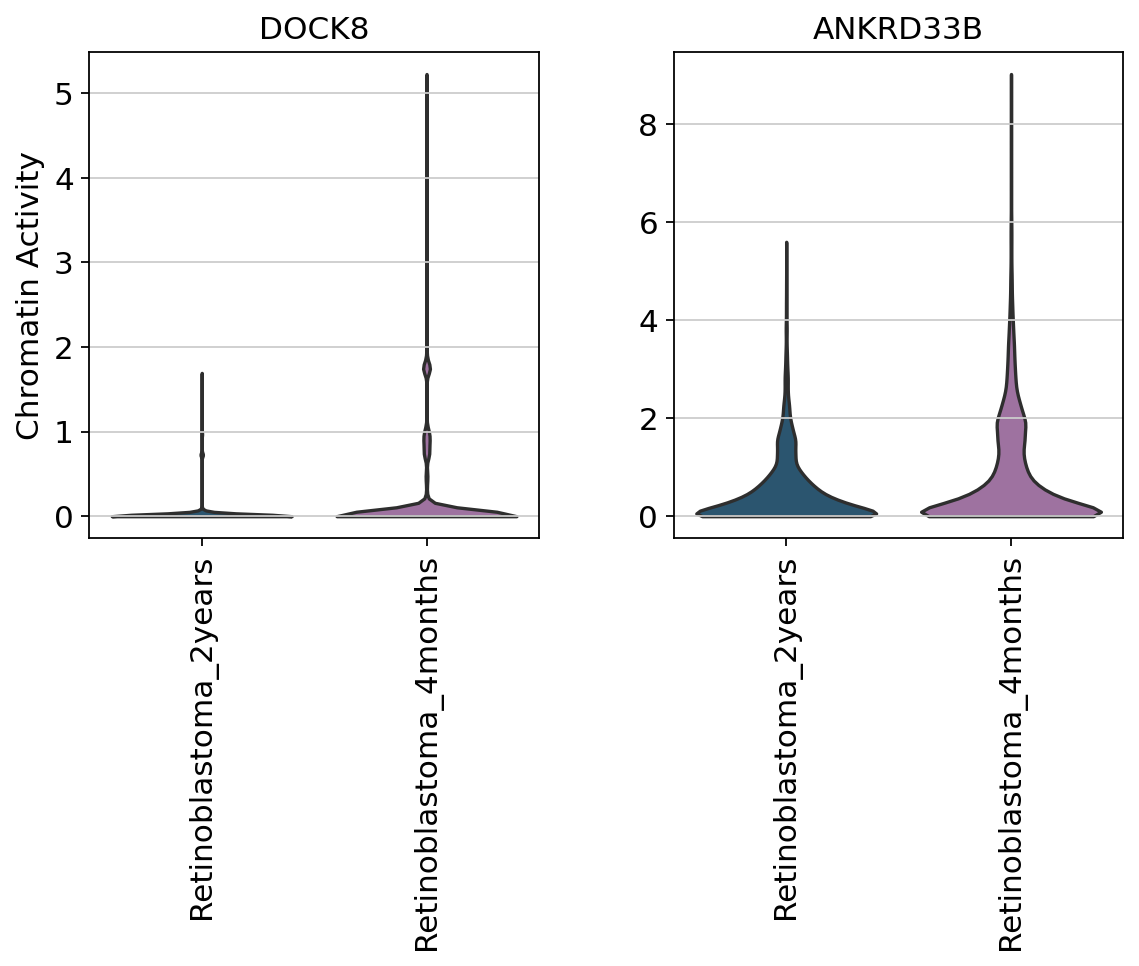

In [111]:
ax=sc.pl.violin(act, ['DOCK8','ANKRD33B'], groupby='Developmental_Stage',fig_size=(2,2),
             stripplot=False, jitter=0.2, multi_panel=False,show=False,)
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=90)
ax[0].set_xlabel('')
ax[0].set_title('DOCK8')
ax[0].set_ylabel('Chromatin Activity')
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90)
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].set_title('ANKRD33B')
plt.savefig(current_path+'result/analysis3/act_violin.png',dpi=300,bbox_inches='tight')

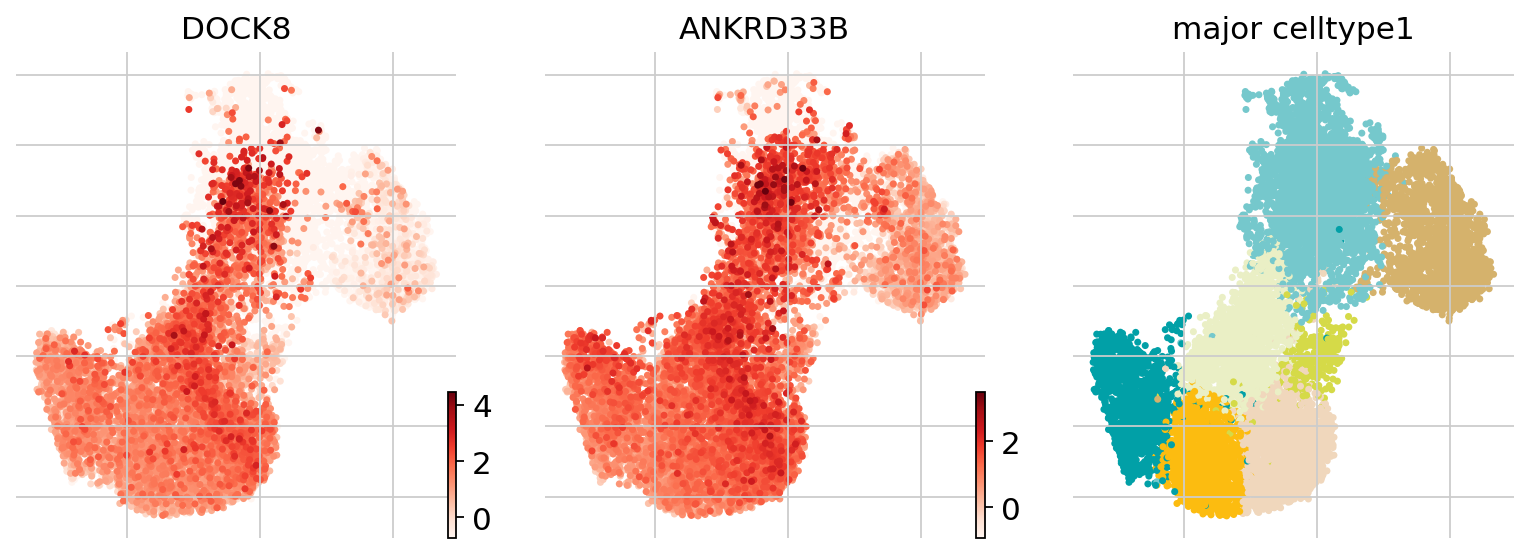

In [113]:
scv.pl.scatter(adata, color=['DOCK8','ANKRD33B','major_celltype1'], color_map='Reds', size=40)